<!-- # CNN autoencoder and Clustering from MTRX data

Use this notebook to load Scienta Omicron Matrix format SPM data and create standardised images for machine learning training and analysis. The code can generate both JPG image data, useful for manually checking the data, and windowed numpy data that can be loaded into ML models. 

The notebook then creates an autoencoder for training on a large dataset, followed by KMEANS clustering. 

**Author**: Steven R. Schofield  
**Created**: November, 2024 -->

# Machine learning autoencoder + Kmeans for STM image data analysis
## Steven R. Schofield (Universtiy College London) Dec. 2024.

### Load required modules

In [42]:
# Define path where to find the module. This allows for a different path depending on where the code is running (my mac or the cluster)
import os
import sys

# Define candidate paths
module_path_list = [
    '/Users/steven/academic-iCloud/Python/modules',
    '/hpc/aklicka/Python/modules'
]

data_path_list = [
    '/Users/steven/Python-data',
    '/hpc/aklicka/Python-data/training-set-1'
]

# Resolve actual paths
module_path = next((p for p in module_path_list if os.path.exists(p)), None)
data_path = next((p for p in data_path_list if os.path.exists(p)), None)

# Check and report missing paths
if module_path is None:
    print("Error: Could not locate a valid module path.")
if data_path is None:
    print("Error: Could not locate a valid data path.")

if module_path is None or data_path is None:
    sys.exit(1)

# Print resolved paths
print(f"module_path = {module_path}")
print(f"data_path = {data_path}")

# Reduce TensorFlow verbosity
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


module_path = /hpc/aklicka/Python/modules
data_path = /hpc/aklicka/Python-data/training-set-1


In [43]:
# # Ensure modules are reloaded 
%load_ext autoreload
%autoreload 2

# Import standard modules
import numpy as np

import platform

from datetime import datetime

# Add custom module path to list
sys.path.append(module_path)

# Import custom module
import SRSML24.data_prep as dp
import SRSML24.model as m
import SRSML24.utils as ut

import tensorflow as tf
#from tensorflow.keras.optimizers.legacy import Adam 
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import pandas as pd
from IPython.display import display, Markdown

import skimage as ski
import skimage.morphology as morphology
import skimage
from skimage import morphology, measure

#import platform 

m.print_system_info()

start_time = dp.current_datetime()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

Python version: 3.9.21 (main, Dec 11 2024, 16:24:11) 
[GCC 11.2.0]
TensorFlow version: 2.4.1
TensorFlow is built with CUDA: True
TensorFlow is built with ROCm: False

System: Linux 4.18.0-553.22.1.el8_10.x86_64 (x86_64)
Platform: Linux-4.18.0-553.22.1.el8_10.x86_64-x86_64-with-glibc2.28
Processor: x86_64

Number of GPUs available to TensorFlow: 1
GPU Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

>>> Running with GPU available <<<  (Linux-4.18.0-553.22.1.el8_10.x86_64-x86_64-with-glibc2.28)

Current time 2025-06-27 15:03:28


### Programme variable setup

In [ ]:
# Parameters for windows creation
# General
job_name = 'June_25_BIG_model'
verbose = False             # Set this True to print out more information

# MTRX preprocessing
flatten_method = 'poly_xy'
pixel_density = 15.0        # Convert all images to a constant pixel density
pixel_ratio = 0.7           # If an image has less than this % in the slow scan direction it is discarded
data_scaling = 1.e9         # Scale the z-height of the data

# Windowing
window_size = 32            # Window size for training/validation
window_pitch = 8            # Window pitch for training/validation

# Data saving options
save_windows = True         # Save the windows as numpy files
together = True             # Set this True to save image windows for a mtrx image as a single file rather than separate files.
save_jpg = False            # Save the full image as a jpg
collate = False             # Set this True to remove all subfolder directories and save all data in root data path
save_window_jpgs = False    # Save the windows as jpgs for inspection

# Parameters for training
model_name = 'unet_' + job_name
batch_size = 128
buffer_size = 12800 # shuffling
learning_rate = 1e-4
epochs = 5

# Parameters for clustering
cluster_model_name = model_name + '_kmeans'
cluster_batch_size = 5120 # This is the number of latent features in a batch for clustering. 
                          # Does not have to be the same as for training and probably should 
                          # be larger. 
cluster_buffer_size = cluster_batch_size * 5    # shuffling buffer
num_clusters=20                                 # Desired number of clusters (centroids) to form in the data.
max_iter=1000                                   # Maximum iterations allowed for each mini-batch to refine centroids.
reassignment_ratio=0.05                         # Fraction of clusters reassigned per step; lower values stabilize updates.

# Parameters for PREDICTIONS
predict_window_pitch = 2                        # Window pitch for prediction
predictions_batch_size = 2**15                  # Batch size for predictions


# DATA LIMITS FOR TESTING THE CODE
mtrx_train_data_limit = None                    # Number of MTRX files to process (training)
mtrx_test_data_limit = None                     # Number of MTRX files to process (validation)

train_data_limit = None                           # Limit the data used in the autoencoder training
test_data_limit = None                          # Limit the data used in the autoencoder training (validation)

# Step 2
feature_extract_alg = 0 
cluster_model_type = "kmeans"

cluster_model_spectral_name = model_name + "_spectral"

max_size_blob = 3000 #maximum pixel area of a blob to keep in the image
area_threshold = 50 #minimum pixel area of a blob to keep in the image
feature_size = 16 #radius of feature window taken from the centroid of the blob, actual window size is 2*feature_size

In [45]:

job_data_path = dp.create_new_data_path(data_path, job_name, include_date=False)

mtrx_train_path = os.path.join(data_path, 'mtrx/train')
mtrx_test_path = os.path.join(data_path, 'mtrx/test')
mtrx_predict_path = os.path.join(data_path, 'mtrx/predict')

# Step 1 paths
model_path = os.path.join(job_data_path,'model')
cluster_model_path = os.path.join(job_data_path,'cluster_model')

latent_features_path = os.path.join(job_data_path, 'latent_features')
predict_latent_features_path = os.path.join(job_data_path, 'latent_features_predictions')

windows_train_path = os.path.join(job_data_path, 'windows/train')
windows_test_path = os.path.join(job_data_path, 'windows/test')
windows_predict_path = os.path.join(job_data_path, 'windows/predict')

predictions_path = os.path.join(job_data_path, f'predictions')

# Step 2 paths
step2_model_path = os.path.join(job_data_path,'step2/model')
step2_cluster_model_path = os.path.join(job_data_path,'step2/cluster_model')

step2_latent_features_train_path = os.path.join(job_data_path, 'step2/latent_features/train')
step2_latent_features_test_path = os.path.join(job_data_path, 'step2/latent_features/test')
step2_latent_features_predict_path = os.path.join(job_data_path, 'step2/latent_features/predict')


step2_predict_latent_features_path = os.path.join(job_data_path, 'step2/latent_features_predictions')


step2_windows_train_path = os.path.join(job_data_path, 'step2/windows/train')
step2_windows_test_path = os.path.join(job_data_path, 'step2/windows/test')
step2_windows_predict_path = os.path.join(job_data_path, 'step2/windows/predict')

step2_predictions_path = os.path.join(job_data_path, f'step2/predictions')



### Process Matrix format data to windows for autoencoder training and validation

In [ ]:
# REMOVE ALL DATA FOLDERS EXCEPT MTRX 
dp.delete_data_folders(job_data_path, subdirectories=["jpg", "windows", "windows-jpg"], override=True)

In [ ]:
# Training data
mtrx_train_file_list, _ = dp.list_files_by_extension(mtrx_train_path,'Z_mtrx',verbose=False)

dp.process_mtrx_files(
    mtrx_train_file_list[0:mtrx_train_data_limit],
    job_data_path, # save data path
    flatten_method = flatten_method, pixel_density = pixel_density, pixel_ratio = pixel_ratio,
    data_scaling = data_scaling, window_size = window_size, window_pitch = window_pitch,
    save_windows = save_windows,
    save_window_jpgs=save_window_jpgs,
    save_jpg = save_jpg,
    together = together,
    collate = collate,
    verbose = verbose
    )

# Test data
mtrx_test_file_list, _ = dp.list_files_by_extension(mtrx_test_path,'Z_mtrx',verbose=False)

dp.process_mtrx_files(
    mtrx_test_file_list[0:mtrx_test_data_limit],
    job_data_path, # save data path
    flatten_method = flatten_method, pixel_density = pixel_density, pixel_ratio = pixel_ratio,
    data_scaling = data_scaling, window_size = window_size, window_pitch = window_pitch,
    save_windows = save_windows,
    save_window_jpgs=save_window_jpgs,
    save_jpg = save_jpg,
    together = together,
    collate = collate,
    verbose = verbose
    )

### Build tensorflow data pipeline for training and validation of autoencoder

In [5]:
# Training data - tensorflow data pipeline for autoencoder
train_files, num_train = dp.list_files_by_extension(windows_train_path, 'npy')
train_files = train_files[:train_data_limit]

# Create dataset with prefetching
train_dataset = m.create_tf_dataset_batched(
    train_files, 
    batch_size=batch_size, 
    buffer_size=buffer_size, 
    window_size=window_size,
    is_autoencoder=True, 
    shuffle=True)

# Validation data - tensorflow data pipeline for autoencoder
test_files, num_test = dp.list_files_by_extension(windows_test_path, 'npy')
test_files = test_files[:test_data_limit]

# Create dataset with prefetching
test_dataset = m.create_tf_dataset_batched(
    test_files, 
    batch_size=batch_size, 
    buffer_size=buffer_size, 
    window_size=window_size,
    is_autoencoder=True, 
    shuffle=True)

Found 728 files with extension 'npy' in directory:
/hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/windows/train
Data pipeline created with 728 files, batch size: 128, window size: 32
Sample batch shape: (128, 32, 32, 1)

Found 282 files with extension 'npy' in directory:
/hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/windows/test
Data pipeline created with 282 files, batch size: 128, window size: 32
Sample batch shape: (128, 32, 32, 1)



Batch 1:
x shape: (128, 32, 32, 1), y shape: (128, 32, 32, 1)


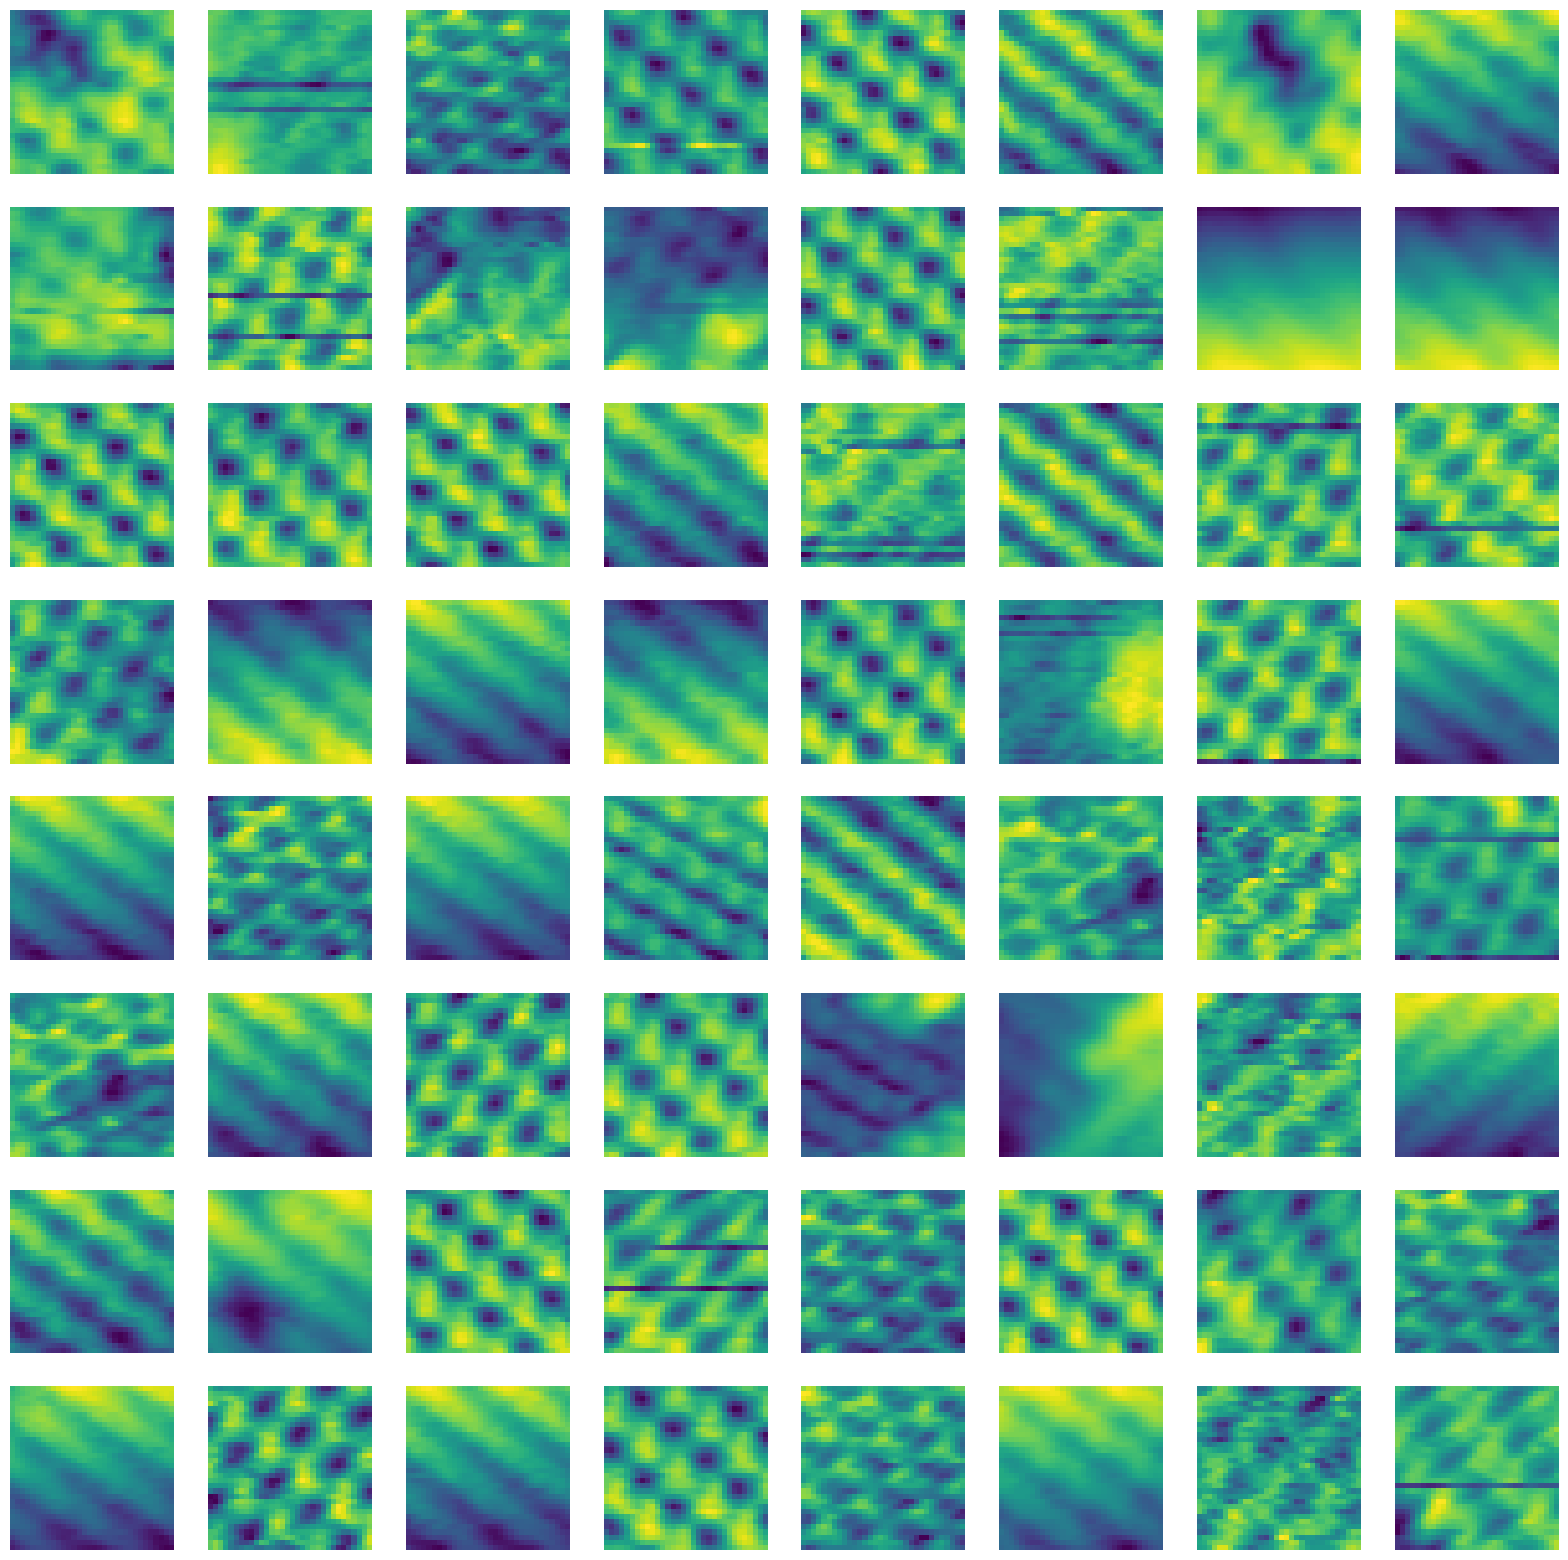

In [7]:
# Display the first 16 images in a 4x4 grid along with their labels
def display_images_with_labels(images, labels, num_images=16):
    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].squeeze(), cmap='viridis')
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

num_images = 64
offset = 0
# show one image with specific index from train_dataset
for i, (x, y) in enumerate(train_dataset):
    if i == 1:  # Show only the first batch
        print(f"Batch {i}:")
        print(f"x shape: {x.shape}, y shape: {y.shape}")
        plt.figure(figsize=(20, 20))
        for index in range(num_images):
            plt.subplot(8, 8, index + 1)
            plt.imshow(x[index + offset].numpy().squeeze(), cmap='viridis')
            #plt.title(f'Label: {labels[index+offset]}')
            plt.axis('off')
        
        plt.show()
        break
    


In [ ]:
# Build and compile the UNET model
autoencoder_model = m.build_autoencoder(window_size=window_size,model_name=model_name)
autoencoder_model.summary()
m.save_model_summary(autoencoder_model, model_path, model_name=model_name)

# Can also save a graphical representation of the model
# This requires pydot and graphviz to be installed
# pip install pydot
# pip install graphviz
# If you are using a Mac, you may need to install graphviz using brew
# brew install graphviz
m.save_model_diagram(autoencoder_model, model_path, model_name=model_name, show_shapes=False, show_layer_names=False, expand_nested=False)

# Check if running on Apple Silicon
is_mac_silicon = platform.system() == "Darwin" and platform.processor() == "arm"

if is_mac_silicon:
    print("Detected Mac with Apple Silicon. Compiling the model with the legacy RMSprop optimizer for compatibility with TensorFlow-metal.")
    autoencoder_model.compile(
        optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=learning_rate),
        loss='mean_squared_error',
        metrics=['mse', 'mae']
    )
else:
    print("Compiling the model with the RMSprop optimizer.")
    autoencoder_model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
        loss='mean_squared_error',
        metrics=['mse', 'mae']
    )



### Train autoencoder

In [ ]:
# Train the model using the tf.data datasets
history = autoencoder_model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=1
)
model_train_time = datetime.now().strftime('%Y%m%d_%H%M%S')
print(f"Model training completed at {model_train_time}")

# Save the model as soon as training completes
m.save_model(autoencoder_model, model_path, model_name=model_name, model_train_time=model_train_time)

end_time = dp.current_datetime()
dp.elapsed_time(start_time,end_time)

### Extract Latent Features

In [ ]:
dp.delete_data_folders(
    job_data_path, 
    subdirectories='latent_features',
    override=True)

In [ ]:
# Load the trained autoencoder model
autoencoder_model = m.load_model(model_path, model_name=model_name)

In [ ]:
# Training data - tensorflow data pipeline 
train_files, num_train = dp.list_files_by_extension(windows_train_path, 'npy')
train_files = train_files[:train_data_limit]

train_dataset = m.create_tf_dataset_batched(
    train_files, 
    batch_size=cluster_batch_size, 
    buffer_size=cluster_buffer_size, 
    window_size=window_size,
    is_autoencoder=True, 
    shuffle=True)

In [ ]:
m.extract_latent_features_to_disk_from_prebatched_windows(
    autoencoder_model, 
    train_dataset, 
    latent_features_path, 
    bottleneck_layer_name='bottleneck',
    features_name='latent_features_train',
    return_array=False,
    verbose=False)

### Train KMEANS using latent features saved to disk

In [ ]:
# List and sort latent feature files
latent_features_files, num_latent_files = dp.list_files_by_extension(latent_features_path, 'npy')

In [ ]:
# Load the latent features from disk into a tensor dataset pipeline
latent_features_dataset = m.create_latent_features_tf_dataset(
    latent_features_files,
    batch_size=cluster_batch_size,
    shuffle=True, 
    shuffle_buffer_size=cluster_buffer_size)

In [ ]:

cluster_model, convergence_history = m.train_kmeans(
    latent_features_dataset,                # tf.data.Dataset containing batches of latent feature vectors.
    batch_size=cluster_batch_size,          # Size of each batch for the KMeans model (controls memory usage and stability).
    num_clusters=num_clusters,              # Desired number of clusters (centroids) to form in the data.
    max_iter=5000000,                      # Maximum iterations allowed for each mini-batch to refine centroids.
    reassignment_ratio=0.01   # Fraction of clusters reassigned per step; lower values stabilize updates.
)
# Save and plot convergence history
m.plot_kmeans_convergence(convergence_history, cluster_model_path, model_name=cluster_model_name)

# Save cluster model
m.save_cluster_model(cluster_model, cluster_model_path, model_name=cluster_model_name)

### Process Matrix format data to windows for making predictions 

In [ ]:
dp.delete_data_folders(
    job_data_path, 
    subdirectories=['windows/predict','windows-jpg/predict','jpg/predict'],
    override=True)

In [ ]:
# Prediction data in MTRX format
mtrx_predict_file_list, _ = dp.list_files_by_extension(mtrx_predict_path,'Z_mtrx',verbose=False)

dp.process_mtrx_files(
    mtrx_predict_file_list,
    job_data_path, # save data path
    flatten_method = flatten_method, pixel_density = pixel_density, pixel_ratio = pixel_ratio,
    data_scaling = data_scaling, window_size = window_size, 
    window_pitch = predict_window_pitch,
    save_windows = save_windows,
    save_window_jpgs=save_window_jpgs,
    save_jpg = save_jpg,
    together = together,
    collate = collate,
    verbose = verbose
)

### Make predictions using the trained autoencoder and KMEANS models

In [74]:
# Load the trained autoencoder
autoencoder_model = m.load_model(model_path, model_name=model_name)

# Load a previously saved cluster model from disk
cluster_model = m.load_cluster_model(cluster_model_path, model_name=cluster_model_name)

Model loaded from: /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/model/unet_June_25_BIG_model.keras
Cluster model loaded from: /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/cluster_model/unet_June_25_BIG_model_kmeans.pkl


In [75]:
# Training data - tensorflow data pipeline 
train_files, num_train = dp.list_files_by_extension(windows_train_path, 'npy')
train_files = train_files[:train_data_limit]

# Get the corresponding image coordimages list file
train_windows_coordinates_file_list , _ = dp.list_files_by_extension(windows_train_path,'.txt',verbose=False)
train_windows_coordinates_file_list = [
    name for name in train_windows_coordinates_file_list 
    if "coordinates" in name
]


Found 728 files with extension 'npy' in directory:
/hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/windows/train
Found 1456 files with extension '.txt' in directory:
/hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/windows/train


In [76]:
# Training data - tensorflow data pipeline 
test_files, num_test = dp.list_files_by_extension(windows_test_path, 'npy')
test_files = test_files[:test_data_limit]

# Get the corresponding image coordimages list file
test_windows_coordinates_file_list , _ = dp.list_files_by_extension(windows_test_path,'.txt',verbose=False)
test_windows_coordinates_file_list = [
    name for name in test_windows_coordinates_file_list 
    if "coordinates" in name
]


Found 282 files with extension 'npy' in directory:
/hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/windows/test
Found 564 files with extension '.txt' in directory:
/hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/windows/test


In [77]:
print(len(test_windows_coordinates_file_list))

282


In [78]:
ut.summarize_parameters(['job_name', 'flatten_method', 'pixel_density', 'pixel_ratio', 'data_scaling', 'window_size', 
                      'window_pitch', 'model_name', 'model_train_time', 'batch_size', 'buffer_size', 'learning_rate', 
                      'epochs', 'cluster_model_name', 'cluster_batch_size', 'cluster_buffer_size', 'num_clusters', 
                      'max_iter', 'reassignment_ratio', 'predict_window_pitch', 'mtrx_train_data_limit', 
                      'mtrx_test_data_limit', 'train_data_limit', 'test_data_limit',], save_path=predictions_path)


Saved parameter summary to /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/predictions/parameter_summary_20250627_153934.csv


Parameter                          Value
0                job_name              June_25_BIG_model
1          flatten_method                        poly_xy
2           pixel_density                           15.0
3             pixel_ratio                            0.7
4            data_scaling                   1000000000.0
5             window_size                             32
6            window_pitch                              8
7              model_name         unet_June_25_BIG_model
8        model_train_time                      undefined
9              batch_size                            128
10            buffer_size                          12800
11          learning_rate                         0.0001
12                 epochs                              5
13     cluster_model_name  unet_June_25_BIG_model_kmeans
14     cluster_batch_size                           5120
15    cluster_buffer_size                          25600
16           num_clusters                             20
17               max_iter                           1000
18     reassignment_ratio                           0.05
19   predict_window_pitch                              2
20  mtrx_train_data_limit                           None
21   mtrx_test_data_limit                           None
22       train_data_limit                           None
23        test_data_limit                           None

### Extract and Save feature windows for training and validation datasets

In [ ]:
dp.delete_data_folders(job_data_path, subdirectories=["step2/windows/train"], override=True)

for image_num in range(len(train_files)):

    prediction_file = train_files[image_num]
    coords_file = train_windows_coordinates_file_list[image_num]

    #get reconstructed image and cluster image
    reconstructed_img, cluster_img = m.reconstruct_predict(prediction_file, coords_file, autoencoder_model, cluster_model, window_size, predictions_batch_size)

    # Detect features and find centers
    #features, centers, labeled_array, num_features = m.detect_features_find_centres(cluster_img, max_size=70000, area_threshold=64,)
    if feature_extract_alg == 0:#detects most features but also lots of noise
        centers = m.detect_centers(cluster_img, min_size=350)
    elif feature_extract_alg==1: # Most conservative, least noise, but does not pick up all the features
        features, centers, labeled_array, num_features = m.detect_features_find_centres(cluster_img, max_size=70000, area_threshold=64,)
    elif feature_extract_alg==2: # middle of the road option
        labeled_array, centers, num_features = m.detect_features_better(cluster_img, max_size=3500, area_threshold=64)
    else:
        centers = m.detect_centers(cluster_img, min_size=350)

    #extract feature windows from the reconstructed image
    feature_windows = m.extract_feature_windows(reconstructed_img, centers, px=feature_size)

    image_name = os.path.splitext(os.path.basename(prediction_file))[0]
    # Save the feature windows to disk for each reconstructed image
    dp.save_feature_windows_together(feature_windows, centers, step2_windows_train_path, base_filename=image_name, verbose=True)



Deleted: /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/step2/windows/train
All specified folders have been successfully deleted.

---
Processing file default_2011Jan28-112629_STM-STM_Spectroscopy--14_1_FU_all_windows.npy
Not shuffling
Data pipeline created with 1 files, batch size: 32768, window size: 32
Sample batch shape: (2226, 32, 32, 1)
.Combined latent features shape: (2226, 4096)
Saved 7 windows to /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/step2/windows/train/default_2011Jan28-112629_STM-STM_Spectroscopy--14_1_FU_all_windows_all_windows.npy
Saved coordinates to /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/step2/windows/train/default_2011Jan28-112629_STM-STM_Spectroscopy--14_1_FU_all_windows_coordinates.txt


---
Processing file default_2011Jan28-112629_STM-STM_Spectroscopy--1_1_BU_all_windows.npy
Not shuffling
Data pipeline created with 1 files, batch size: 32768, window size: 32
Sample batch shape: (2650, 32, 32, 1)
.Combined latent feat

### Extract feature windows from the test (validation) dataset

In [79]:
#dp.delete_data_folders(job_data_path, subdirectories=["feature_windows/train"], override=True)
dp.delete_data_folders(job_data_path, subdirectories=["step2/windows/test"], override=True)

for image_num in range(len(test_files)):
    
    prediction_file = test_files[image_num]  
    coords_file = test_windows_coordinates_file_list[image_num]  

    image_name = os.path.splitext(os.path.basename(prediction_file))[0]


#get reconstructed image and cluster image
    reconstructed_img, cluster_img = m.reconstruct_predict(prediction_file, coords_file, autoencoder_model, cluster_model, window_size, predictions_batch_size)

    # Detect features and find centers
    #features, centers, labeled_array, num_features = m.detect_features_find_centres(cluster_img, max_size=70000, area_threshold=64,)
    if feature_extract_alg == 0:#detects most features but also lots of noise
        centers = m.detect_centers(cluster_img, min_size=350)
    elif feature_extract_alg==1: # Most conservative, least noise, but does not pick up all the features
        features, centers, labeled_array, num_features = m.detect_features_find_centres(cluster_img, max_size=70000, area_threshold=64,)
    elif feature_extract_alg==2: # middle of the road option
        labeled_array, centers, num_features = m.detect_features_better(cluster_img, max_size=3500, area_threshold=64)
    else:
        centers = m.detect_centers(cluster_img, min_size=350)

    #extract feature windows from the reconstructed image
    feature_windows = m.extract_feature_windows(reconstructed_img, centers, px=feature_size)

    # Save the feature windows to disk for each reconstructed image
    dp.save_feature_windows_together(feature_windows, centers, step2_windows_test_path, base_filename=image_name, verbose=True)





Deleted: /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/step2/windows/test
All specified folders have been successfully deleted.

---
Processing file default_2011Aug01-135432_STM-STM_Spectroscopy--3_1_BU_all_windows.npy
Not shuffling
Data pipeline created with 1 files, batch size: 32768, window size: 32
Sample batch shape: (8100, 32, 32, 1)
.Combined latent features shape: (8100, 4096)
Saved 136 windows to /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/step2/windows/test/default_2011Aug01-135432_STM-STM_Spectroscopy--3_1_BU_all_windows_all_windows.npy
Saved coordinates to /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/step2/windows/test/default_2011Aug01-135432_STM-STM_Spectroscopy--3_1_BU_all_windows_coordinates.txt


---
Processing file default_2011Aug01-135432_STM-STM_Spectroscopy--3_1_FU_all_windows.npy
Not shuffling
Data pipeline created with 1 files, batch size: 32768, window size: 32
Sample batch shape: (8100, 32, 32, 1)
.Combined latent features

## Retrain autoencoder on feature windows. Save as `step2_autoencoder`

In [7]:
# Load the trained autoencoder model
step2_autoencoder_model = m.load_model(model_path, model_name=model_name)

Model loaded from: /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/model/unet_June_25_BIG_model.keras


### Create tf dataset from feature windows

In [104]:
# Training data - tensorflow data pipeline 
step2_train_files, step2_num_train = dp.list_files_by_extension(step2_windows_train_path, 'npy')
step2_train_files = step2_train_files[:train_data_limit]

step2_train_dataset_feature_windows = m.create_tf_dataset_batched(
    step2_train_files, 
    batch_size=batch_size, 
    buffer_size=buffer_size, 
    window_size=feature_size*2,  # feature windows are 2*feature_size
    is_autoencoder=True, 
    shuffle=True)

Found 728 files with extension 'npy' in directory:
/hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/step2/windows/train
Data pipeline created with 728 files, batch size: 128, window size: 32
Sample batch shape: (128, 32, 32, 1)



In [105]:
# Validation data - tensorflow data pipeline 
step2_test_files, step2_num_test = dp.list_files_by_extension(step2_windows_test_path, 'npy')
step2_test_files = step2_test_files[:test_data_limit]

step2_test_dataset_feature_windows = m.create_tf_dataset_batched(
    step2_test_files, 
    batch_size=batch_size, 
    buffer_size=buffer_size, 
    window_size=feature_size*2,  # feature windows are 2*feature_size
    is_autoencoder=True, 
    shuffle=True)

Found 282 files with extension 'npy' in directory:
/hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/step2/windows/test
Data pipeline created with 282 files, batch size: 128, window size: 32
Sample batch shape: (128, 32, 32, 1)



Batch 0:
x shape: (128, 32, 32, 1), y shape: (128, 32, 32, 1)


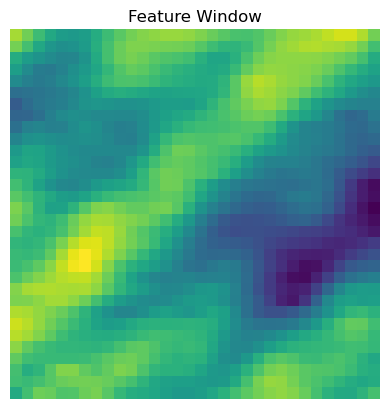

In [10]:
# show one image with specific index from train_dataset
for i, (x, y) in enumerate(step2_train_dataset_feature_windows):
    if i == 0:  # Show only the first batch
        print(f"Batch {i}:")
        print(f"x shape: {x.shape}, y shape: {y.shape}")
        plt.imshow(x[2].numpy().squeeze(), cmap='viridis')
        plt.title('Feature Window')
        plt.axis('off')
        plt.show()
    break


Batch 0:
x shape: (128, 32, 32, 1), y shape: (128, 32, 32, 1)


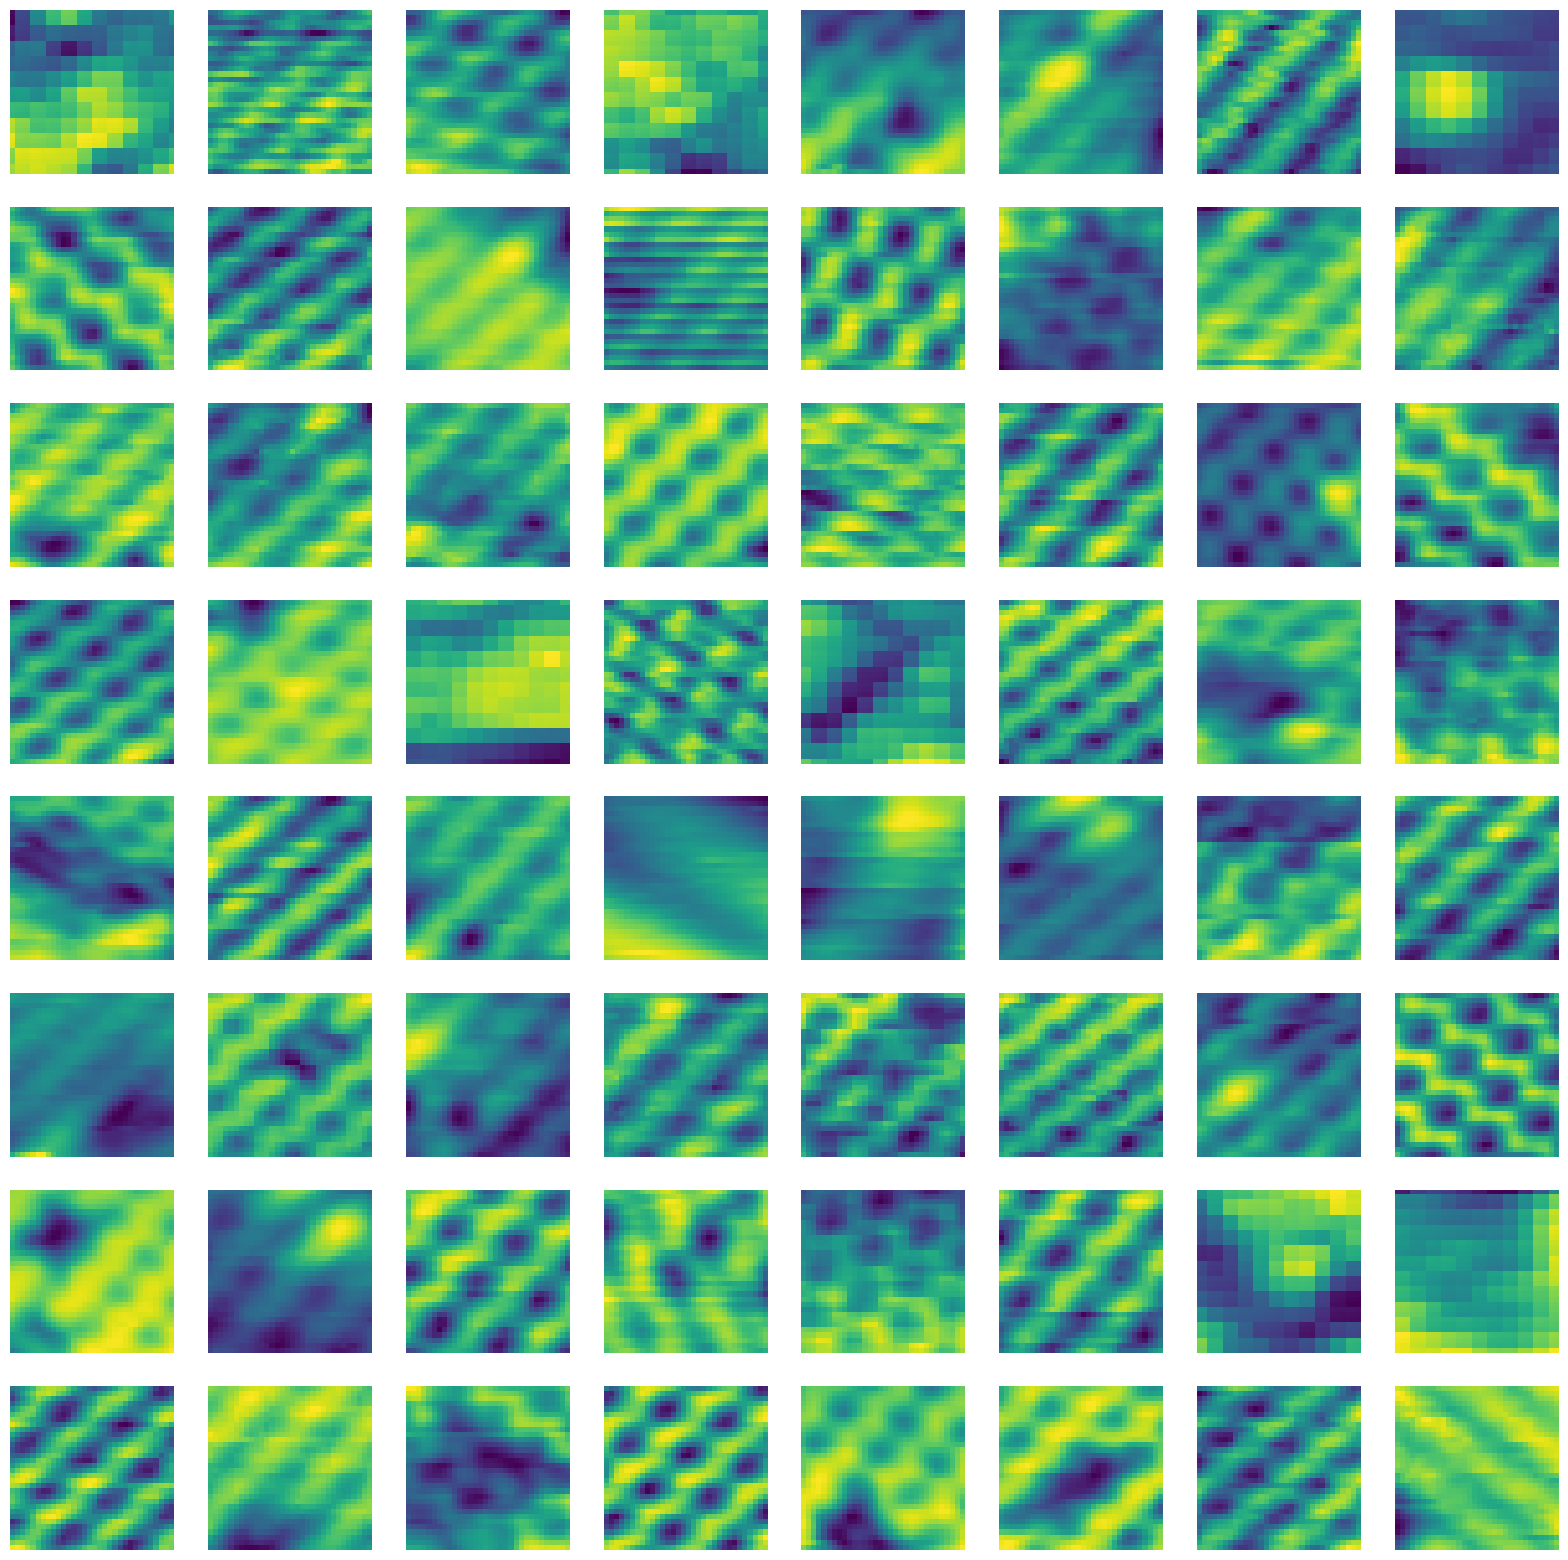

In [11]:
# Display the first 16 images in a 4x4 grid along with their labels
def display_images_with_labels(images, labels, num_images=16):
    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].squeeze(), cmap='viridis')
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

num_images = 64
offset = 0
# show one image with specific index from train_dataset
for i, (x, y) in enumerate(step2_test_dataset_feature_windows):
    if i == 0:  # Show only the first batch
        print(f"Batch {i}:")
        print(f"x shape: {x.shape}, y shape: {y.shape}")
        plt.figure(figsize=(20, 20))
        for index in range(num_images):
            plt.subplot(8, 8, index + 1)
            plt.imshow(x[index + offset].numpy().squeeze(), cmap='viridis')
            #plt.title(f'Label: {labels[index+offset]}')
            plt.axis('off')
        
        plt.show()
    break


### Retrain autoencoder on feature windows

In [26]:
# Check if running on Apple Silicon
is_mac_silicon = platform.system() == "Darwin" and platform.processor() == "arm"

if is_mac_silicon:
    print("Detected Mac with Apple Silicon. Compiling the model with the legacy RMSprop optimizer for compatibility with TensorFlow-metal.")
    step2_autoencoder_model.compile(
        optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=learning_rate),
        loss='mean_squared_error',
        metrics=['mse', 'mae']
    )
else:
    print("Compiling the model with the RMSprop optimizer.")
    step2_autoencoder_model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
        loss='mean_squared_error',
        metrics=['mse', 'mae']
    )




Compiling the model with the RMSprop optimizer.


### Retrain autoencoder on feature windows and save as a new model in `step2/model`

In [27]:
# Train the model using the tf.data datasets
history = step2_autoencoder_model.fit(
    step2_train_dataset_feature_windows,
    validation_data=step2_test_dataset_feature_windows,
    epochs=epochs,
    shuffle=True,
    verbose=1
)
model_train_time = datetime.now().strftime('%Y%m%d_%H%M%S')
print(f"Model training completed at {model_train_time}")

# Save the model as soon as training completes
m.save_model(step2_autoencoder_model, step2_model_path, model_name=model_name, model_train_time=model_train_time)

end_time = dp.current_datetime()
dp.elapsed_time(start_time,end_time)

Epoch 1/5
170/170 [==============================] - 10s 43ms/step - loss: 5.3389e-06 - mse: 5.3389e-06 - mae: 0.0016 - val_loss: 1.0239e-05 - val_mse: 1.0239e-05 - val_mae: 0.0021
Epoch 2/5
170/170 [==============================] - 7s 38ms/step - loss: 3.9084e-06 - mse: 3.9084e-06 - mae: 0.0017 - val_loss: 8.8930e-06 - val_mse: 8.8930e-06 - val_mae: 0.0014
Epoch 3/5
170/170 [==============================] - 7s 38ms/step - loss: 3.7952e-06 - mse: 3.7952e-06 - mae: 0.0016 - val_loss: 9.6613e-06 - val_mse: 9.6613e-06 - val_mae: 0.0019
Epoch 4/5
170/170 [==============================] - 7s 38ms/step - loss: 3.8573e-06 - mse: 3.8573e-06 - mae: 0.0017 - val_loss: 8.9633e-06 - val_mse: 8.9633e-06 - val_mae: 0.0017
Epoch 5/5
170/170 [==============================] - 7s 38ms/step - loss: 3.9175e-06 - mse: 3.9175e-06 - mae: 0.0017 - val_loss: 9.5044e-06 - val_mse: 9.5044e-06 - val_mae: 0.0017
Model training completed at 20250624_140933
Model saved at: /hpc/aklicka/Python-data/training-set-1

### Extract latent vectors from feature windows using the new autoencoder

In [106]:
# Load the trained autoencoder model
step2_autoencoder_model = m.load_model(step2_model_path, model_name=model_name)

Model loaded from: /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/step2/model/unet_June_25_BIG_model.keras


In [107]:
dp.delete_data_folders(job_data_path, subdirectories=["step2/latent_features/train"], override=True)


m.extract_latent_features_to_disk_from_prebatched_windows(
    step2_autoencoder_model, 
    step2_train_dataset_feature_windows, 
    step2_latent_features_train_path, 
    bottleneck_layer_name='bottleneck',
    features_name='step2_latent_features_train',
    return_array=False,
    verbose=True)

dp.delete_data_folders(job_data_path, subdirectories=["step2/latent_features/test"], override=True)


m.extract_latent_features_to_disk_from_prebatched_windows(
    step2_autoencoder_model, 
    step2_test_dataset_feature_windows, 
    step2_latent_features_test_path, 
    bottleneck_layer_name='bottleneck',
    features_name='step2_latent_features_test',
    return_array=False,
    verbose=True)


No target folders found to delete.
Processing batch 1, input shape: [128  32  32   1]
Latent features shape for batch 1: (128, 4096)
Saved latent features for batch 1 to /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/step2/latent_features/train/step2_latent_features_train_batch_0.npy
Processing batch 2, input shape: [128  32  32   1]
Latent features shape for batch 2: (128, 4096)
Saved latent features for batch 2 to /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/step2/latent_features/train/step2_latent_features_train_batch_1.npy
Processing batch 3, input shape: [128  32  32   1]
Latent features shape for batch 3: (128, 4096)
Saved latent features for batch 3 to /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/step2/latent_features/train/step2_latent_features_train_batch_2.npy
Processing batch 4, input shape: [128  32  32   1]
Latent features shape for batch 4: (128, 4096)
Saved latent features for batch 4 to /hpc/aklicka/Python-data/training-set-1/June_25

In [108]:
# List and sort latent feature files
step2_train_latent_files, num_latent_files = dp.list_files_by_extension(step2_latent_features_train_path, 'npy')

step2_test_latent_files, num_latent_files_test = dp.list_files_by_extension(step2_latent_features_test_path, 'npy')


Found 170 files with extension 'npy' in directory:
/hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/step2/latent_features/train
Found 81 files with extension 'npy' in directory:
/hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/step2/latent_features/test


In [109]:
# Load the latent features from disk into a tensor dataset pipeline
step2_train_latent_dataset = m.create_latent_features_tf_dataset(
    step2_train_latent_files,
    batch_size=cluster_batch_size,
    shuffle=True, 
    shuffle_buffer_size=cluster_buffer_size)

# Load the latent features from disk into a tensor dataset pipeline
step2_test_latent_dataset = m.create_latent_features_tf_dataset(
    step2_test_latent_files,
    batch_size=cluster_batch_size,
    shuffle=True, 
    shuffle_buffer_size=cluster_buffer_size)


Data pipeline created with 170 files, batch size: 5120
Shuffling enabled with buffer size: 25600
Batch shape: (5120, 4096)
Data pipeline created with 81 files, batch size: 5120
Shuffling enabled with buffer size: 25600
Batch shape: (5120, 4096)


### Train clustering using latent features saved to disk

### DBSCAN - Did not end up being useful

In [110]:
cluster_model_dbscan = m.train_dbscan(
    step2_train_latent_dataset,
    eps = 0.7,
    min_samples = 5)

Batch 1 processed
Batch 2 processed
Batch 3 processed
Batch 4 processed
Batch 5 processed


In [111]:
print(f"Number of clusters found: {len(set(cluster_model_dbscan.labels_)) - (1 if -1 in cluster_model_dbscan.labels_ else 0)}")

Number of clusters found: 1


### Spectral clustering

In [112]:
cluster_model_spectral = m.train_spectral_clustering(step2_train_latent_dataset, n_clusters=5, affinity='nearest_neighbors', n_neighbors=10)

# Save cluster model
m.save_cluster_model(cluster_model_spectral, step2_cluster_model_path, model_name=cluster_model_spectral_name)

Cluster model saved at: /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/step2/cluster_model/unet_June_25_BIG_model_spectral.pkl


### K-means

Batch 1 processed. Inertia: 757.2440185546875
Batch 2 processed. Inertia: 769.4623413085938
Batch 3 processed. Inertia: 742.7088012695312
Batch 4 processed. Inertia: 742.1345825195312
Batch 5 processed. Inertia: 189.57359313964844
[Info] Raw convergence data saved to /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/step2/cluster_model/unet_June_25_BIG_model_kmeans_convergence.txt
[Info] Convergence plot saved to /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/step2/cluster_model/unet_June_25_BIG_model_kmeans_convergence.jpg


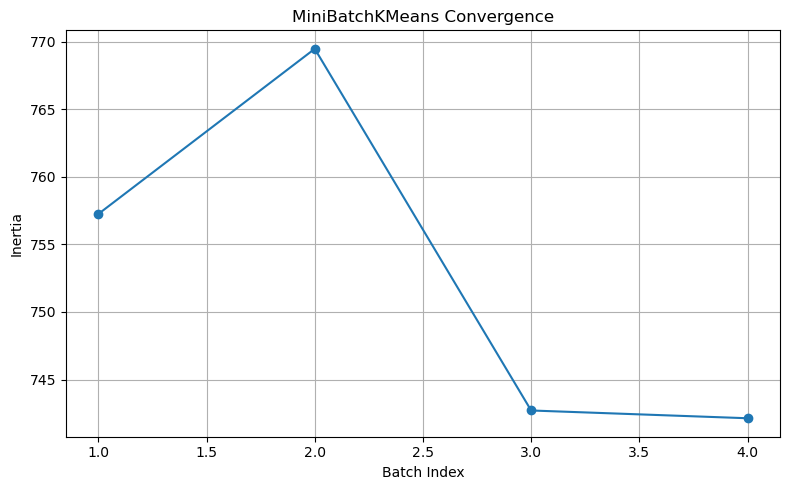

Cluster model saved at: /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/step2/cluster_model/unet_June_25_BIG_model_kmeans.pkl


In [113]:

cluster_model_feature_windows, convergence_history = m.train_kmeans(
    step2_train_latent_dataset,                # tf.data.Dataset containing batches of latent feature vectors.
    batch_size=cluster_batch_size,          # Size of each batch for the KMeans model (controls memory usage and stability).
    num_clusters=20,              # Desired number of clusters (centroids) to form in the data.
    max_iter=5000000,                      # Maximum iterations allowed for each mini-batch to refine centroids.
    reassignment_ratio=0.01   # Fraction of clusters reassigned per step; lower values stabilize updates.
)
# Save and plot convergence history
m.plot_kmeans_convergence(convergence_history, step2_cluster_model_path, model_name=cluster_model_name)

# Save cluster model
m.save_cluster_model(cluster_model_feature_windows, step2_cluster_model_path, model_name=cluster_model_name)

In [114]:
data = np.load(step2_train_latent_files[0])
labels = cluster_model_feature_windows.predict(data)
#labels = cluster_model_dbscan.fit_predict(data)

#labels = cluster_model_spectral.fit_predict(data)
print(data.shape)

(128, 4096)


In [115]:
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score

score = calinski_harabasz_score(data, labels)
print(f"Calinski-Harabasz Score: {score:.3f}")

sil_score = silhouette_score(data, labels)
print(f"Silhouette Score: {sil_score:.3f}")#

Calinski-Harabasz Score: 49.521
Silhouette Score: 0.124


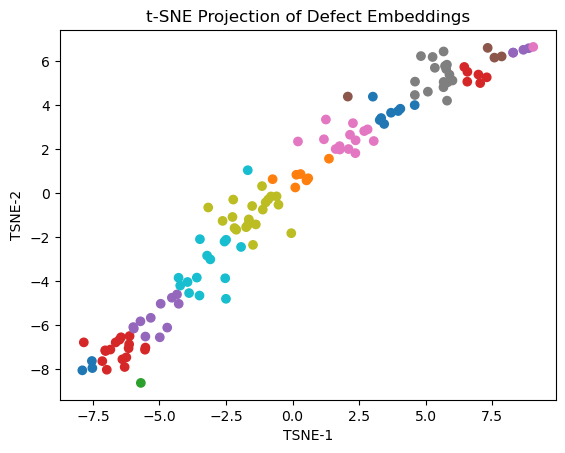

In [116]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
latent_2d = tsne.fit_transform(data)

plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10')
plt.title('t-SNE Projection of Defect Embeddings')
plt.xlabel('TSNE-1')
plt.ylabel('TSNE-2')
#plt.legend(labels.unique(labels), title='Cluster Labels', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

Batch 0:
x shape: (128, 32, 32, 1), y shape: (128, 32, 32, 1)


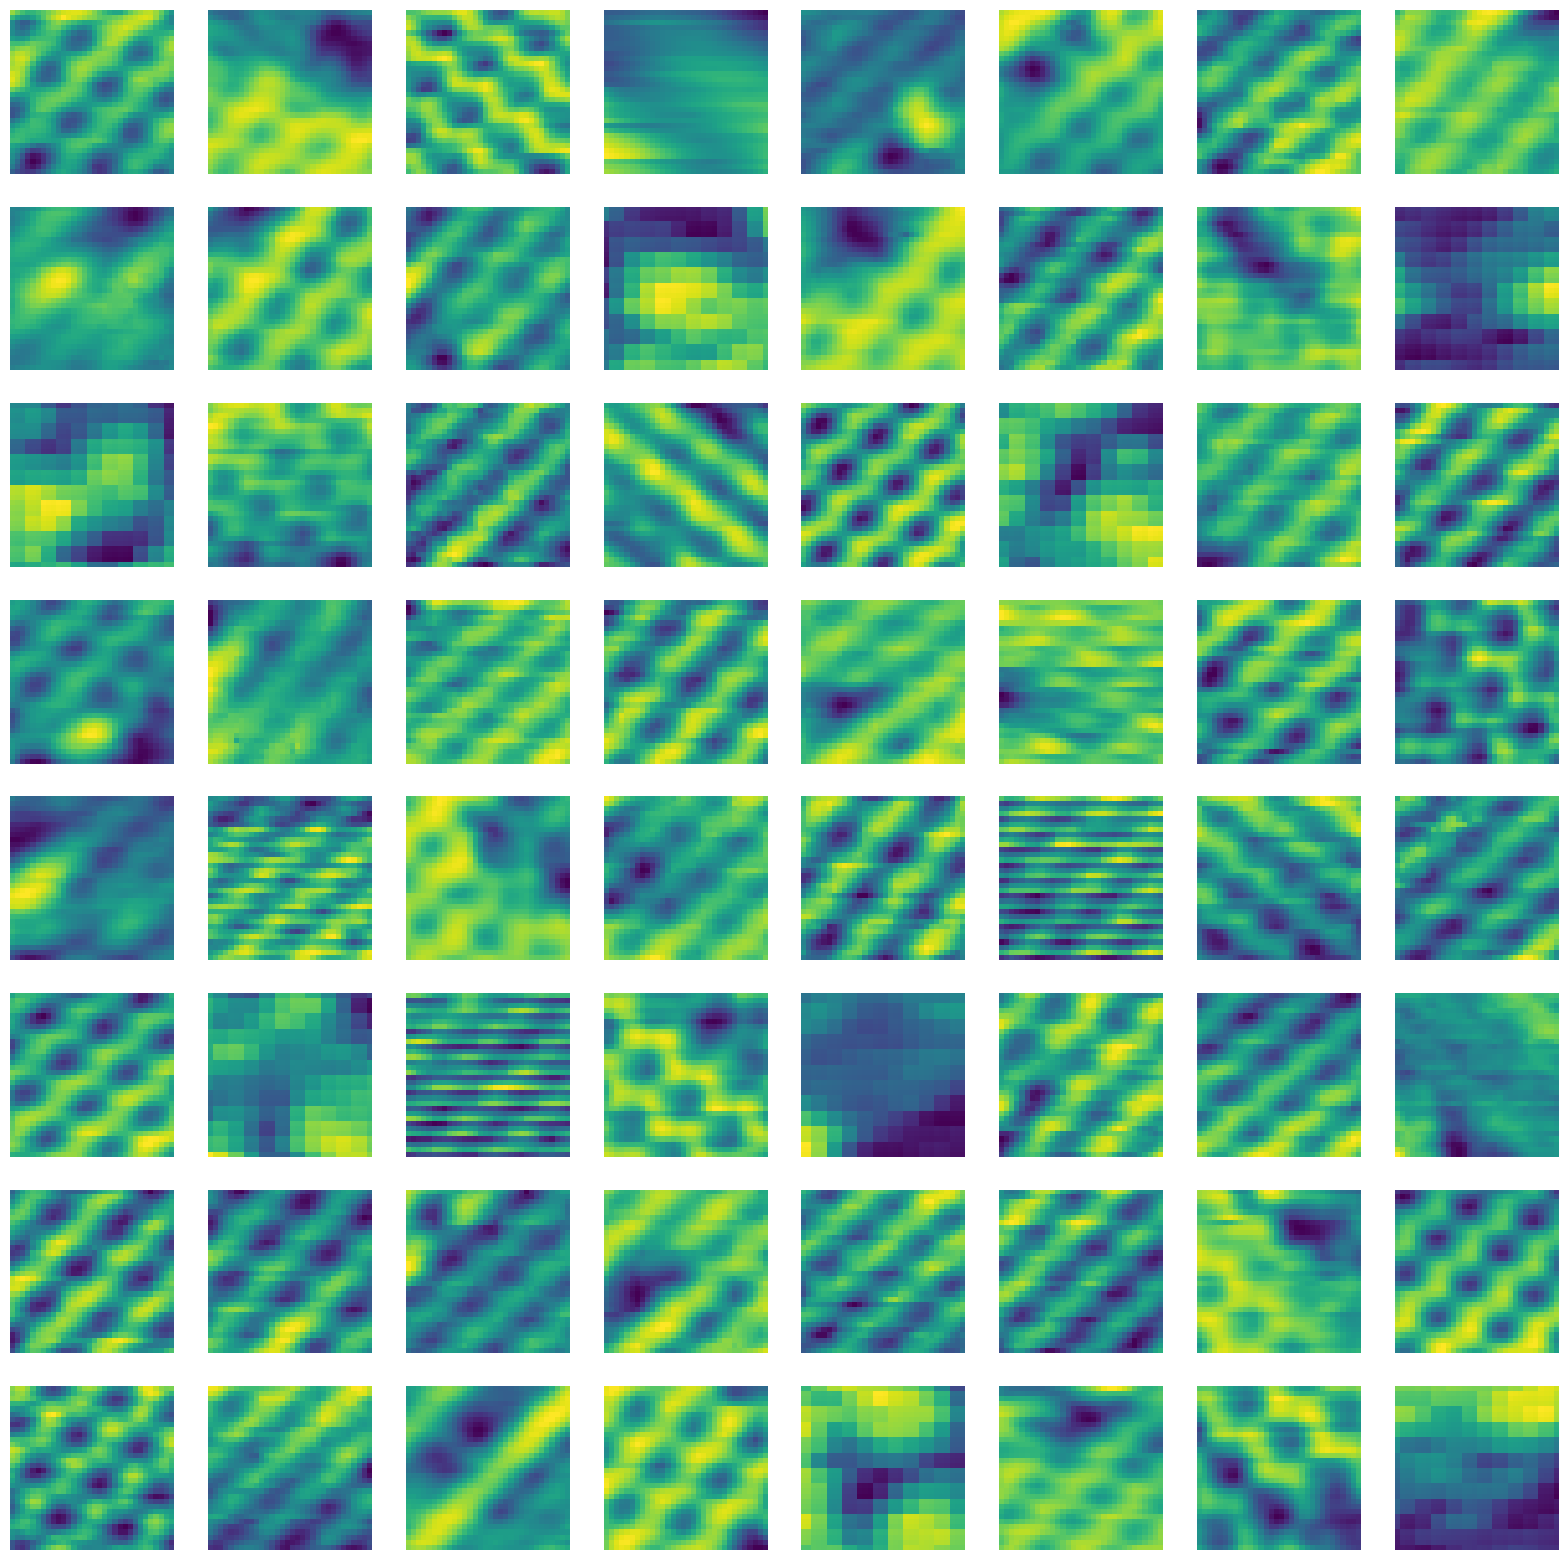

In [117]:
# Display the first 16 images in a 4x4 grid along with their labels
def display_images_with_labels(images, labels, num_images=16):
    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].squeeze(), cmap='viridis')
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

num_images = 64
offset = 0
# show one image with specific index from train_dataset
for i, (x, y) in enumerate(step2_test_dataset_feature_windows): 
    if i == 0:  # Show only the first batch
        print(f"Batch {i}:")
        print(f"x shape: {x.shape}, y shape: {y.shape}")
        plt.figure(figsize=(20, 20))
        for index in range(num_images):
            plt.subplot(8, 8, index + 1)
            plt.imshow(x[index + offset].numpy().squeeze(), cmap='viridis')
            #plt.title(f'Label: {labels[index+offset]}')
            plt.axis('off')
        
        plt.show()
    break


### Testing on prediction dataset

In [118]:
# Load the trained autoencoder
autoencoder_model = m.load_model(model_path, model_name=model_name)

# Load a previously saved cluster model from disk
cluster_model = m.load_cluster_model(cluster_model_path, model_name=cluster_model_name)

Model loaded from: /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/model/unet_June_25_BIG_model.keras
Cluster model loaded from: /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/cluster_model/unet_June_25_BIG_model_kmeans.pkl


In [119]:
step1_predict_files, step1_num_predict = dp.list_files_by_extension(windows_predict_path, 'npy')

# Get the corresponding image coordimages list file
step1_prediction_windows_coordinates_file_list , _ = dp.list_files_by_extension(windows_predict_path,'.txt',verbose=False)
step1_prediction_windows_coordinates_file_list = [
    name for name in step1_prediction_windows_coordinates_file_list 
    if "coordinates" in name
]


Found 32 files with extension 'npy' in directory:
/hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/windows/predict
Found 64 files with extension '.txt' in directory:
/hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/windows/predict


### Extracts feature windows from a list of images using a trained autoencoder and clustering model, and saves them to disk.

Save functionality as `m.extract_and_save_feature_windows`

For each image in the provided file list, this function:
  1. Reconstructs the image and generates a cluster label map using the autoencoder and clustering model.
  2. Detects features (e.g., defects, molecules) in the cluster image using one of several feature extraction algorithms.
  3. Extracts square windows centered on the detected features from the reconstructed image.
  4. Saves the extracted feature windows and their coordinates to disk for later use.


In [121]:
dp.delete_data_folders(job_data_path, subdirectories=["step2/windows/predict"], override=True)

image_num = 2
feature_extract_alg = 0 # 0: detect_centers, 1: detect_features_find_centres, 2: detect_features_better

# select the image and coordinates of images to predict on - full image since this is step 1
prediction_file = step1_predict_files[image_num]  
coords_file = step1_prediction_windows_coordinates_file_list[image_num]  

# image name for saving
image_name = os.path.splitext(os.path.basename(prediction_file))[0]


# Extracting the feature windows from a single image
#get reconstructed image and cluster image
reconstructed_img, cluster_img = m.reconstruct_predict(prediction_file, coords_file, autoencoder_model, cluster_model, window_size, predictions_batch_size)

# Detect features and find centers
#features, centers, labeled_array, num_features = m.detect_features_find_centres(cluster_img, max_size=70000, area_threshold=64,)
if feature_extract_alg == 0:#detects most features but also lots of noise
    centers = m.detect_centers(cluster_img, min_size=350)
elif feature_extract_alg==1: # Most conservative, least noise, but does not pick up all the features
    features, centers, labeled_array, num_features = m.detect_features_find_centres(cluster_img, max_size=70000, area_threshold=64,)
elif feature_extract_alg==2: # middle of the road option
    labeled_array, centers, num_features = m.detect_features_better(cluster_img, max_size=3500, area_threshold=64)
else:
    centers = m.detect_centers(cluster_img, min_size=350)

#extract feature windows from the reconstructed image
feature_windows = m.extract_feature_windows(reconstructed_img, centers, px=feature_size)

# Save the feature windows to disk for each reconstructed image
dp.save_feature_windows_together(feature_windows, centers, step2_windows_predict_path, base_filename=image_name, verbose=True)


Deleted: /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/step2/windows/predict
All specified folders have been successfully deleted.

---
Processing file default_2011Feb11-105510_STM-STM_Spectroscopy--110_16_FD_all_windows.npy
Not shuffling
Data pipeline created with 1 files, batch size: 32768, window size: 32
Sample batch shape: (32768, 32, 32, 1)
......Combined latent features shape: (189225, 4096)
Saved 210 windows to /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/step2/windows/predict/default_2011Feb11-105510_STM-STM_Spectroscopy--110_16_FD_all_windows_all_windows.npy
Saved coordinates to /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/step2/windows/predict/default_2011Feb11-105510_STM-STM_Spectroscopy--110_16_FD_all_windows_coordinates.txt



### Step 2

In [122]:
# Load the trained autoencoder
step2_autoencoder_model = m.load_model(step2_model_path, model_name=model_name)


# Load a previously saved cluster model from disk
step2_cluster_model_kmeans = m.load_cluster_model(step2_cluster_model_path, model_name=cluster_model_name)
step2_cluster_model_spectral = m.load_cluster_model(step2_cluster_model_path, model_name=cluster_model_spectral_name)


Model loaded from: /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/step2/model/unet_June_25_BIG_model.keras
Cluster model loaded from: /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/step2/cluster_model/unet_June_25_BIG_model_kmeans.pkl
Cluster model loaded from: /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/step2/cluster_model/unet_June_25_BIG_model_spectral.pkl


### Displays the feature windows according to their cluster label

The function `predict_labels_from_feature_windows` takes an argument `cluster_model` and `cluster_model_type` which determine which cluster model to use. the default is "kmeans" and the other option is "spectral". To change the cluster model used, you must provide a different `cluster_model` as well as `cluster_model_type`

In [ ]:
#dp.delete_data_folders(job_data_path, subdirectories=["step2/predictions"], override=True)


Deleted: /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/step2/predictions
All specified folders have been successfully deleted.


### Step 2: Cluster Feature windows. Display labeled features.

Step 2 only uses windows cut around the found features in the image. The latent vectors for step 2 are related to the 'feature' windows.


The function `predict_labels_from_feature_windows` takes an argument `cluster_model` and `cluster_model_type` which determine which cluster model to use. the default is "kmeans" and the other option is "spectral". To change the cluster model used, you must provide a different `cluster_model` as well as `cluster_model_type`

Found 1 files with extension 'npy' in directory:
/hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/step2/windows/predict
Not shuffling
Data pipeline created with 1 files, batch size: 32768, window size: 32
Sample batch shape: (210, 32, 32, 1)

Deleted: /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/step2/latent_features/predict
All specified folders have been successfully deleted.
Processing batch 1, input shape: [210  32  32   1]
Latent features shape for batch 1: (210, 4096)
Saved latent features for batch 1 to /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/step2/latent_features/predict/feature_windows_latent_features_predict_batch_0.npy

All latent features have been saved to /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/step2/latent_features/predict.
Sample batch shape: (210, 4096)
Found 1 files with extension 'npy' in directory:
/hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/step2/latent_features/predict
Found 1 files with exten

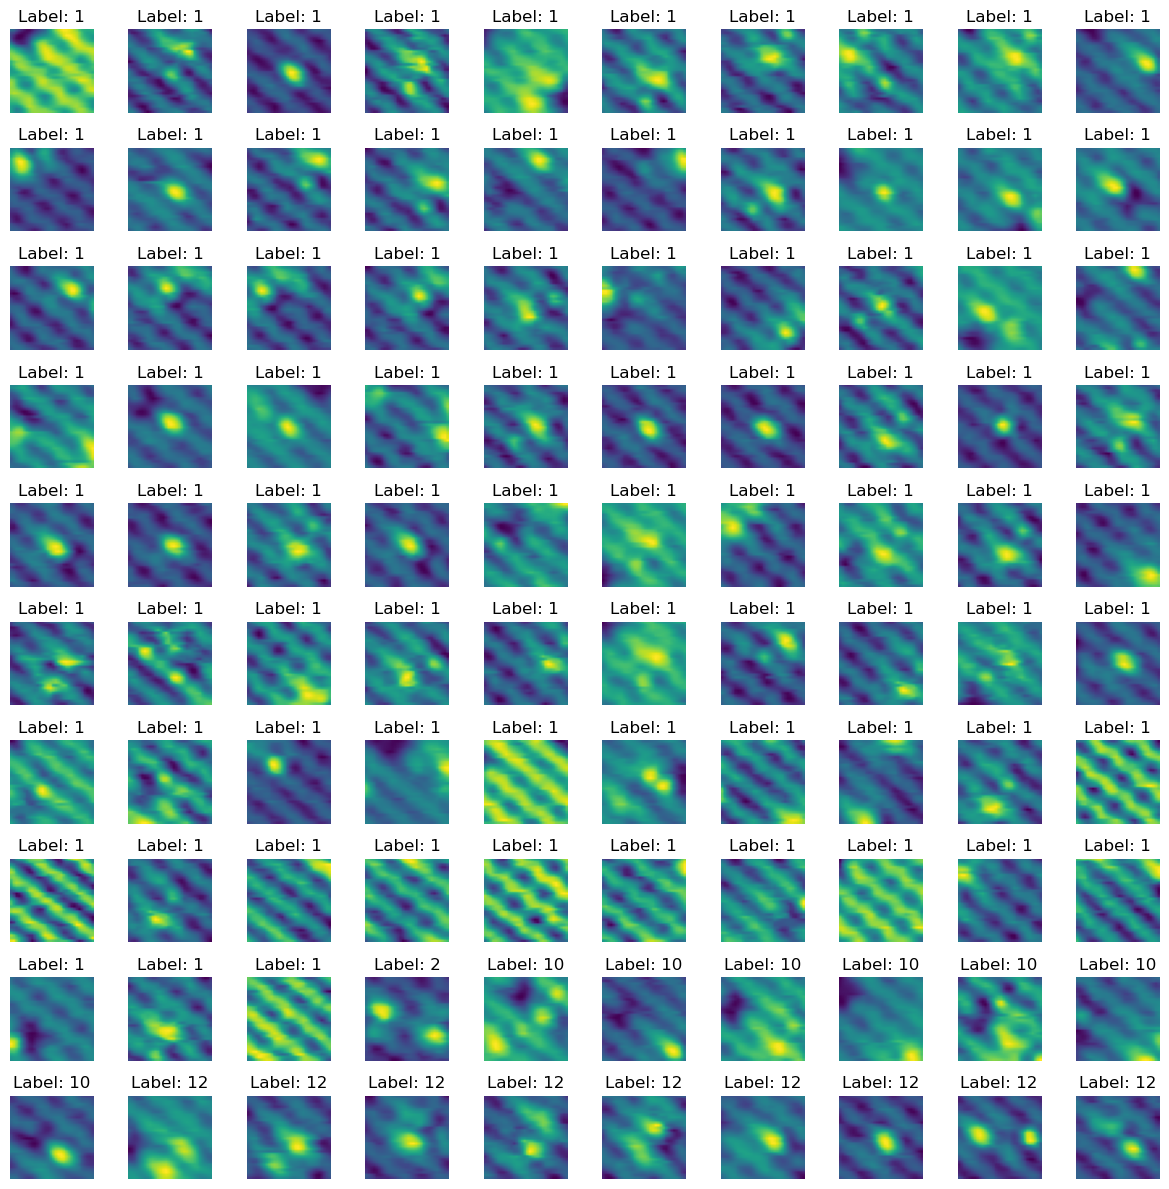

Saved 210 windows to /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/step2/predictions/default_2011Feb11-105510_STM-STM_Spectroscopy--110_16_FD_all_windows.npy
Saved coordinates to /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/step2/predictions/default_2011Feb11-105510_STM-STM_Spectroscopy--110_16_FD_all_windows_coordinates.txt



In [123]:
# Step 2
#    Predicts labels (int) for each feature window of the original image.
windows, labels = m.predict_labels_from_feature_windows(step2_windows_predict_path, step2_latent_features_predict_path, job_data_path, step2_autoencoder_model, step2_cluster_model_kmeans,
                                                        cluster_model_type="kmeans", feature_size = 16, predictions_batch_size=2**15)

# Get the corresponding feature window image coordimages list file
step2_prediction_windows_coordinates_file_list , _ = dp.list_files_by_extension(step2_windows_predict_path,'.txt',verbose=False)
step2_prediction_windows_coordinates_file_list = [
    name for name in step2_prediction_windows_coordinates_file_list 
    if "coordinates" in name
]

# coordinates of the feature windows
coords = np.loadtxt(step2_prediction_windows_coordinates_file_list[0], skiprows=1, dtype=float).astype(np.int64)


# Sort the labels numerically, while also sorting the corresponding feature windows, and feature coordinates
sorted_indices = np.argsort(labels)
sorted_labels = labels[sorted_indices]
sorted_feature_windows = windows[sorted_indices]
sorted_coords = coords[sorted_indices]


m.display_feature_windows_with_labels(sorted_feature_windows, sorted_labels, num_images=min(windows.shape[0],100))
# the coordinates are saved in the format [y, x, label] where y is the row index and x is the column index in the image
# label is the predicted label for the feature window.
dp.save_feature_windows_coords_and_labels(sorted_feature_windows, sorted_coords, sorted_labels, step2_predictions_path, base_filename=image_name, verbose=True)


### Display reconstructed image with differently coloured square labels highlighting the features

You can also choose to only display certain labels using the label_num array. There is an option to also display the cluster image if you need to assess how well the feature extraction works.


---
Processing file default_2011Feb11-105510_STM-STM_Spectroscopy--110_16_FD_all_windows.npy
Not shuffling
Data pipeline created with 1 files, batch size: 32768, window size: 32
Sample batch shape: (32768, 32, 32, 1)
......Combined latent features shape: (189225, 4096)
Found 1 files with extension '.txt' in directory:
/hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/step2/windows/predict


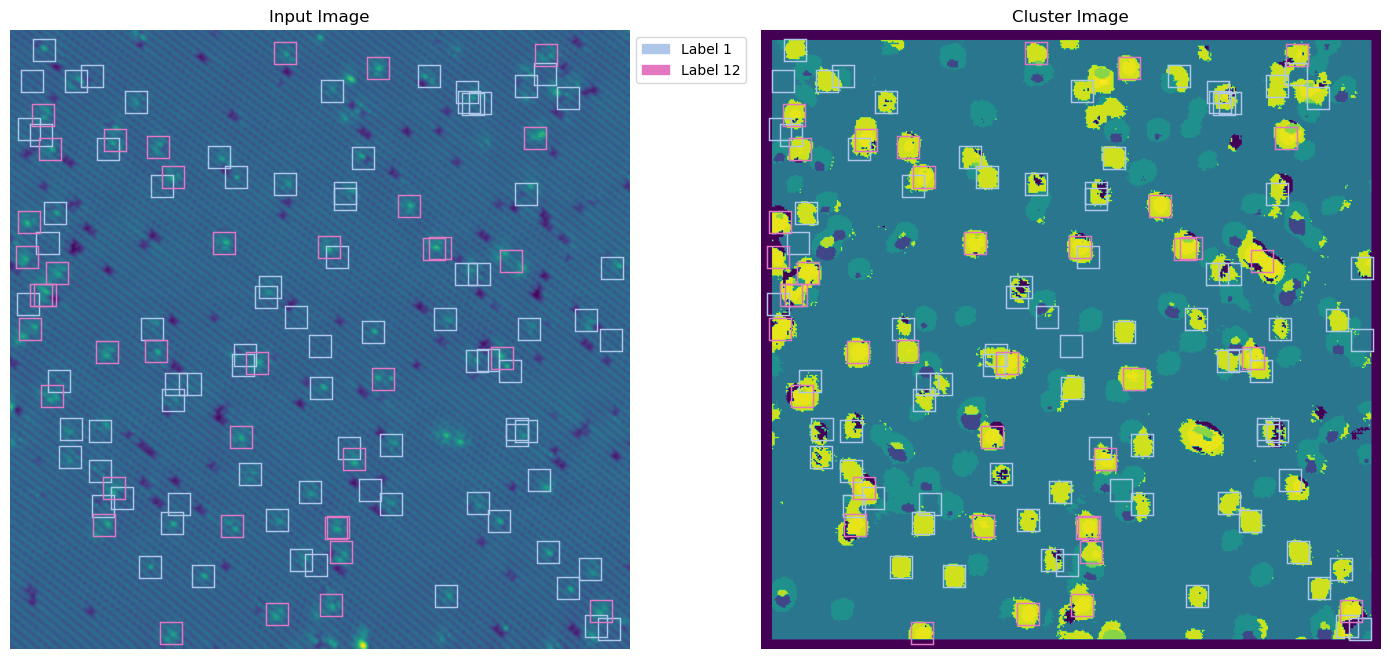

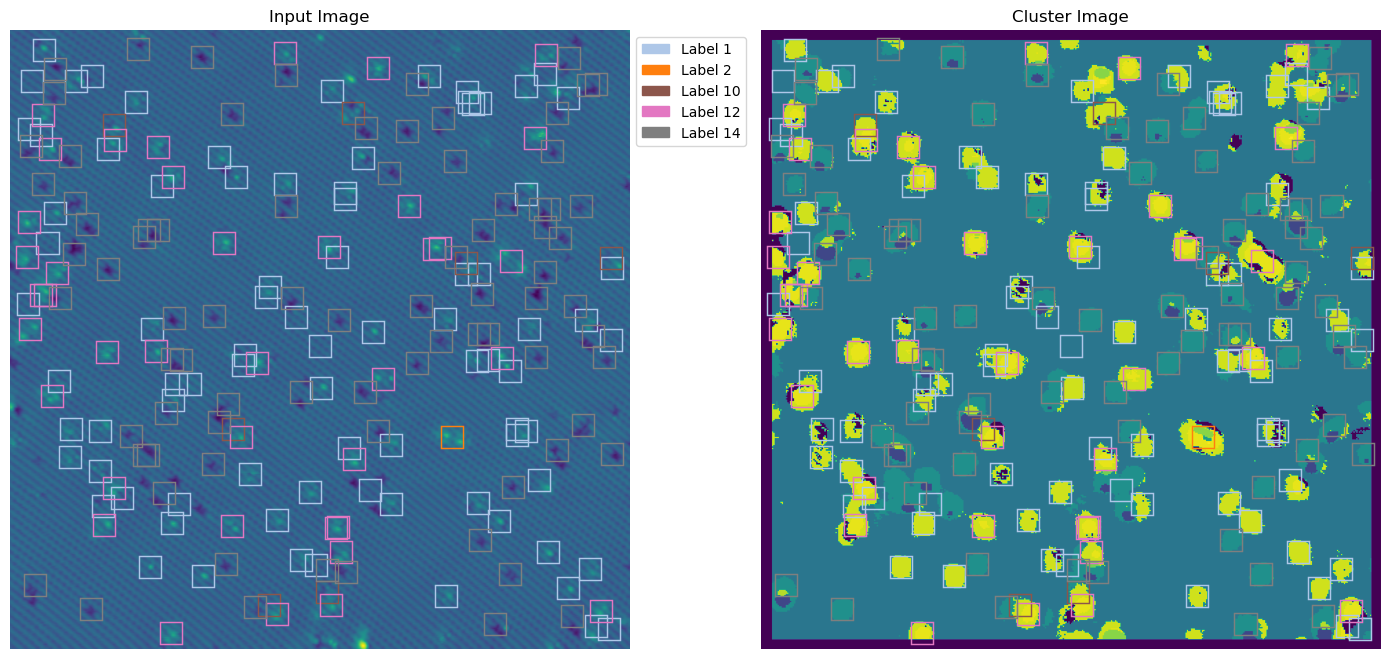

In [125]:

#get reconstructed image and cluster image
reconstructed_img, cluster_img = m.reconstruct_predict(step1_predict_files[image_num], step1_prediction_windows_coordinates_file_list[image_num], autoencoder_model, cluster_model, window_size, predictions_batch_size)

# Get the corresponding image coordimages list file
step2_prediction_windows_coordinates_file_list , _ = dp.list_files_by_extension(step2_windows_predict_path,'.txt',verbose=False)

# Get the coordinates for a specific image with index `image_num`
coordinates_data = np.loadtxt(step2_prediction_windows_coordinates_file_list[0], skiprows=1, dtype=float).astype(np.int64)

# Show the original image with all found features in different coloured squares
m.display_labels_on_image(reconstructed_img, coordinates_data, labels, label_num=[1,12], show_cluster_img=True, cluster_img=cluster_img)

m.display_labels_on_image(reconstructed_img, coordinates_data, labels, label_num=[], show_cluster_img=True, cluster_img=cluster_img)

### Now that the feature windows coordinates and labels are saved, we can load them to check if everything works properly

All predictions are stored in `step2/predictions`. This includes the feature windows, their coordinates and labels.

Note: I am differentiating between predictions_files and predict_files.
Predict files are files which can be used for making predictions.

Predictions_files are files that are the result of making predictions

In [70]:
step2_predictions_files, step2_num_predictions = dp.list_files_by_extension(step2_predictions_path, 'npy')

# Get the corresponding image coordimages list file
step2_predictions_coordinates_file_list , _ = dp.list_files_by_extension(step2_predictions_path,'.txt',verbose=False)
step2_predictions_coordinates_file_list = [
    name for name in step2_predictions_coordinates_file_list 
    if "coordinates" in name]

Found 10 files with extension 'npy' in directory:
/hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/step2/predictions
Found 10 files with extension '.txt' in directory:
/hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/step2/predictions


In [72]:
windows = np.load(step2_predictions_files[0])
coordinates = np.loadtxt(step2_predictions_coordinates_file_list[0], skiprows=1, dtype=float).astype(np.int64)
# We are getting the right number of windows and coordinates
print(f"Number of windows: {windows.shape[0]}")
print(f"Coordinates shape: {coordinates.shape}")

Number of windows: 169
Coordinates shape: (169, 3)


In [101]:
print(coordinates[:10])  # Display the first 10 coordinates

[[707 260   2]
 [685 189   2]
 [325  85   2]
 [618 180   2]
 [503 219   2]
 [414 576   2]
 [488 125   4]
 [504 337   4]
 [487 303   4]
 [445 827   4]]


# Graveyard

Below is a collection of failed ideas

In [ ]:
# List and sort latent feature files
predict_feature_windows_latent_features_files, num_latent_files = dp.list_files_by_extension(step2_latent_features_predict_path, 'npy')

In [ ]:
# Load the latent features from disk into a tensor dataset pipeline
predict_feature_windows_latent_features_dataset = m.create_latent_features_tf_dataset(
    predict_feature_windows_latent_features_files,
    batch_size=cluster_batch_size,
    shuffle=False, 
    shuffle_buffer_size=cluster_buffer_size)

In [ ]:
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score

score = calinski_harabasz_score(data, labels)
print(f"Calinski-Harabasz Score: {score:.3f}")

sil_score = silhouette_score(data, labels)
print(f"Silhouette Score: {sil_score:.3f}")#

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
latent_2d = tsne.fit_transform(data)

plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10')
plt.title('t-SNE Projection of Defect Embeddings')
plt.xlabel('TSNE-1')
plt.ylabel('TSNE-2')
#plt.legend(labels.unique(labels), title='Cluster Labels', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

### testing out the feature detection

In [41]:
# Load a previously saved cluster model from disk
cluster_model = m.load_cluster_model(cluster_model_path, model_name=cluster_model_name)
autoencoder_model = m.load_model(model_path, model_name=model_name)

# Get the list of image windows files to make predictions on
predict_data_files_list, predict_data_files_num = dp.list_files_by_extension(windows_predict_path,'.npy',verbose=False)
# Get the corresponding image coordimages list file
image_windows_coordinates_file_list , _ = dp.list_files_by_extension(windows_predict_path,'.txt',verbose=False)
image_windows_coordinates_file_list = [
    name for name in image_windows_coordinates_file_list 
    if "coordinates" in name
]#

Cluster model loaded from: /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/cluster_model/unet_June_25_BIG_model_kmeans.pkl
Model loaded from: /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/model/unet_June_25_BIG_model.keras
Found 32 files with extension '.npy' in directory:
/hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/windows/predict
Found 64 files with extension '.txt' in directory:
/hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/windows/predict


In [20]:
image_num = 29
prediction_file = predict_data_files_list[image_num]  
coords_file = image_windows_coordinates_file_list[image_num]  

#get reconstructed image and cluster image
reconstructed_img, cluster_img = m.reconstruct_predict(prediction_file, coords_file, autoencoder_model, cluster_model, window_size, predictions_batch_size)

data = cluster_img.astype("int32")
print(np.bincount(data.ravel()))

# Detect features and find centers
features, centers, labeled_array, num_features = m.detect_features_find_centres(cluster_img, max_size=70000, area_threshold=64)
#display the images and extracted features
m.display_reconstructed_and_cluster_images_and_extracted_features(
    reconstructed_img, 
    cluster_img, 
    features, 
    centers, 
    save_to_disk=False,
)


---
Processing file default_2024Aug07-153010_STM-STM_Spectroscopy--9_1_BU_all_windows.npy
Not shuffling
Data pipeline created with 1 files, batch size: 32768, window size: 32
Sample batch shape: (32768, 32, 32, 1)


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run Shape: Dst tensor is not initialized. [Op:Shape]

In [1]:
image_num = 29
prediction_file = predict_data_files_list[image_num]  
coords_file = image_windows_coordinates_file_list[image_num]  

#get reconstructed image and cluster image
reconstructed_img, cluster_img = m.reconstruct_predict(prediction_file, coords_file, autoencoder_model, cluster_model, window_size, predictions_batch_size)

data = cluster_img.astype("int32")
print(np.bincount(data.ravel()))

# Detect features and find centers
features, centers, labeled_array, num_features = m.detect_features_find_centres(cluster_img, max_size=70000, area_threshold=64)
print("Method 1")
#display the images and extracted features
m.display_reconstructed_and_cluster_images_and_extracted_features(
    reconstructed_img, 
    cluster_img, 
    features, 
    centers, 
    save_to_disk=False,
)

labeled_array, centers, num_features = m.detect_features_better(cluster_img, max_size=3000, area_threshold=100, min_area=100)
#display the images and extracted features
print("Method 2")
m.display_reconstructed_and_cluster_images_and_extracted_features(
    reconstructed_img, 
    cluster_img, 
    labeled_array, 
    centers, 
    save_to_disk=False,
)




NameError: name 'predict_data_files_list' is not defined

### Another feature extraction attempt

In [3]:

#get reconstructed image and cluster image
reconstructed_img, cluster_img = m.reconstruct_predict(step1_predict_files[image_num], step1_prediction_windows_coordinates_file_list[image_num], autoencoder_model, cluster_model, window_size, predictions_batch_size)


NameError: name 'm' is not defined

In [ ]:
from skimage.morphology import remove_small_objects, remove_small_holes, closing, disk

# Example: focus on cluster label 2 (modify as needed)
binary_mask = (cluster_img == 2)

# Fill small holes
cleaned = closing(binary_mask, disk(2))
cleaned = remove_small_objects(cleaned, min_size=30)
cleaned = remove_small_holes(cleaned, area_threshold=30)


In [ ]:
from skimage.measure import label, regionprops

label_img = label(cleaned)
regions = regionprops(label_img)

centroids = [r.centroid for r in regions]
print("Number of detected features:", len(centroids))


### Watershed segmentation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.segmentation import watershed
from skimage.feature import peak_local_max

image = cluster_img.astype("int64")

NameError: name 'cluster_img' is not defined

In [ ]:
# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
distance = ndi.distance_transform_edt(image)
coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=image)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-distance, markers, mask=image)

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

### Feature extraction using spectral clustering

In [ ]:
from sklearn.feature_extraction import image

graph = image.img_to_graph(cluster_img)

In [ ]:
graph.data = np.exp(-graph.data / graph.data.std())

In [ ]:
import matplotlib.pyplot as plt

from sklearn.cluster import spectral_clustering

labels = spectral_clustering(graph, n_clusters=4, eigen_solver="arpack")


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axs[0].matshow(cluster_img)
axs[1].matshow(labels)

plt.show()

### Intensity based RAG

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology
from skimage.segmentation import relabel_sequential
from skimage import graph
#from skimage.segmentation import merge_hierarchical
from skimage.measure import label, regionprops
from skimage.morphology import closing, disk, remove_small_objects, remove_small_holes

# Normalize and relabel clusters to have sequential IDs
cluster_labels, _, _ = relabel_sequential(cluster_img.astype(int))
image = reconstructed_img / np.max(reconstructed_img)  # normalize grayscale image

# === RAG MERGING SETUP ===

def _weight_mean_color(graph, src, dst, n):
    diff = np.abs(graph.nodes[src]['mean color'] - graph.nodes[dst]['mean color'])
    return {'weight': diff}

def _merge_condition(graph, src, dst, thresh=0.5):
    return graph.edges[src, dst]['weight'] < thresh

rag = graph.rag_mean_color(image, cluster_labels, mode='similarity')

# Merge regions hierarchically across boundaries
merged_labels = graph.merge_hierarchical(cluster_labels, rag,
                                   thresh=0.001,
                                   rag_copy=False,
                                   in_place_merge=True,
                                   merge_func=_merge_condition,
                                   weight_func=_weight_mean_color)

# === FEATURE CENTROID DETECTION ===

plt.figure(figsize=(6, 6))
plt.imshow(merged_labels, cmap='viridis')

for merged_id in np.unique(merged_labels):
    if merged_id == 0:
        continue  # Skip background

    binary_mask = (merged_labels == merged_id)

    # Clean mask
    cleaned = closing(binary_mask, disk(2))
    cleaned = remove_small_objects(cleaned, min_size=500)
    cleaned = remove_small_holes(cleaned, area_threshold=500)
    cleaned = morphology.erosion(cleaned)

    # Label connected components
    labeled = label(cleaned)
    regions = regionprops(labeled)

    # Plot centroids
    for region in regions:
        y, x = region.centroid
        plt.plot(x, y, 'ro', markersize=2)

plt.title("Centroids After Cluster Merging (RAG)")
plt.axis('off')
plt.tight_layout()
plt.show()


### laplacian local merging

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
from skimage import morphology, filters
from skimage.segmentation import relabel_sequential
from skimage import graph
from skimage.measure import label, regionprops
from skimage.morphology import closing, disk, remove_small_objects, remove_small_holes

# --- INPUTS ---
# cluster_img = your cluster label map (2D)
# reconstructed_img = the grayscale STM image corresponding to it (2D)

# Normalize and relabel clusters to have sequential IDs
cluster_labels, _, _ = relabel_sequential(cluster_img.astype(int))
image = reconstructed_img / np.max(reconstructed_img)  # normalize grayscale image

# --- COMPUTE LAPLACIAN ---
lap = np.abs(filters.laplace(image))  # highlight contours and blob-like structures

# --- BUILD CUSTOM RAG BASED ON MEAN LAPLACIAN MAGNITUDE ---
rag = graph.RAG(cluster_labels)

for region_id in np.unique(cluster_labels):
    region_mask = cluster_labels == region_id
    rag.add_node(region_id)
    rag.nodes[region_id]['mean lap'] = np.mean(lap[region_mask])
    rag.nodes[region_id]['labels'] = [region_id]  # <-- Add this line


for region1 in np.unique(cluster_labels):
    for region2 in np.unique(cluster_labels):
        if region1 >= region2:
            continue
        border = morphology.binary_dilation(cluster_labels == region1) & morphology.binary_dilation(cluster_labels == region2)
        if np.any(border):
            rag.add_edge(region1, region2)
            diff = np.abs(rag.nodes[region1]['mean lap'] - rag.nodes[region2]['mean lap'])
            rag.edges[region1, region2]['weight'] = diff

# --- MERGE FUNCTION ---
def weight_mean_laplacian(graph, src, dst, n):
    diff = np.abs(graph.nodes[src]['mean lap'] - graph.nodes[dst]['mean lap'])
    return {'weight': diff}

def merge_condition_laplacian(graph, src, dst, thresh=0.02):
    return graph.edges[src, dst]['weight'] < thresh

# --- HIERARCHICAL MERGE ---
merged_labels = graph.merge_hierarchical(cluster_labels, rag,
                                         thresh=0.0001,
                                         rag_copy=False,
                                         in_place_merge=True,
                                         merge_func=merge_condition_laplacian,
                                         weight_func=weight_mean_laplacian)

# --- CENTROID DETECTION ---
plt.figure(figsize=(6, 6))
plt.imshow(merged_labels, cmap='viridis')

for merged_id in np.unique(merged_labels):
    if merged_id == 0:
        continue  # Skip background

    binary_mask = (merged_labels == merged_id)

    # Clean mask
    cleaned = closing(binary_mask, disk(2))
    cleaned = remove_small_objects(cleaned, min_size=30)
    cleaned = remove_small_holes(cleaned, area_threshold=30)
    cleaned = morphology.erosion(cleaned)

    labeled = label(cleaned)
    regions = regionprops(labeled)

    # Plot centroids
    for region in regions:
        y, x = region.centroid
        plt.plot(x, y, 'ro', markersize=2)

plt.title("Centroids After Laplacian-Based RAG Merging")
plt.axis('off')
plt.tight_layout()
plt.show()


### Gradient based RAG

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, segmentation, color, morphology
from skimage import graph
from skimage.measure import label, regionprops
from skimage.morphology import closing, disk, remove_small_objects, remove_small_holes
from skimage.graph import merge_hierarchical

original_img = cluster_img.astype(int)
# Compute gradient magnitude image
gradient = filters.sobel(original_img)  # or filters.scharr

# Normalize cluster labels
labels = cluster_img.astype(int)

# === Define custom RAG using gradient ===

def weight_mean_gradient(graph, src, dst, n):
    diff = np.abs(graph.nodes[src]['mean grad'] - graph.nodes[dst]['mean grad'])
    return {'weight': diff}

def merge_condition(graph, src, dst, thresh=0.05):
    return graph.edges[src, dst]['weight'] < thresh

# Compute RAG using mean gradient of each region
rag = graph.RAG(labels)
for region in np.unique(labels):
    mask = labels == region
    rag.add_node(region)
    rag.nodes[region]['mean grad'] = np.mean(gradient[mask])
    rag.nodes[region]['labels'] = [region]  # <-- Add this line


for region1 in np.unique(labels):
    for region2 in np.unique(labels):
        if region1 >= region2:
            continue
        mask1 = labels == region1
        mask2 = labels == region2
        border = morphology.binary_dilation(mask1) & morphology.binary_dilation(mask2)
        if np.any(border):
            rag.add_edge(region1, region2)

# Compute weights
for edge in rag.edges:
    rag.edges[edge]['weight'] = np.abs(
        rag.nodes[edge[0]]['mean grad'] - rag.nodes[edge[1]]['mean grad']
    )

# Merge regions based on gradient similarity
merged_labels = merge_hierarchical(labels, rag,
                                   thresh=0.00000001,
                                   rag_copy=False,
                                   in_place_merge=True,
                                   merge_func=merge_condition,
                                   weight_func=weight_mean_gradient)

# === Detect centroids as before ===

plt.figure(figsize=(6, 6))
plt.imshow(merged_labels, cmap='viridis')

for merged_id in np.unique(merged_labels):
    if merged_id == 0:
        continue

    binary_mask = (merged_labels == merged_id)
    cleaned = closing(binary_mask, disk(2))
    cleaned = remove_small_objects(cleaned, min_size=30)
    cleaned = remove_small_holes(cleaned, area_threshold=30)
    cleaned = morphology.erosion(cleaned)

    labeled = label(cleaned)
    regions = regionprops(labeled)

    for region in regions:
        y, x = region.centroid
        plt.plot(x, y, 'ro', markersize=2)

plt.title("Merged by Gradient RAG - Centroids")
plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
from skimage import data, segmentation, filters, color
from skimage import graph
from matplotlib import pyplot as plt


def weight_boundary(graph, src, dst, n):
    """
    Handle merging of nodes of a region boundary region adjacency graph.

    This function computes the `"weight"` and the count `"count"`
    attributes of the edge between `n` and the node formed after
    merging `src` and `dst`.


    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    n : int
        A neighbor of `src` or `dst` or both.

    Returns
    -------
    data : dict
        A dictionary with the "weight" and "count" attributes to be
        assigned for the merged node.

    """
    default = {'weight': 0.0, 'count': 0}

    count_src = graph[src].get(n, default)['count']
    count_dst = graph[dst].get(n, default)['count']

    weight_src = graph[src].get(n, default)['weight']
    weight_dst = graph[dst].get(n, default)['weight']

    count = count_src + count_dst
    return {
        'count': count,
        'weight': (count_src * weight_src + count_dst * weight_dst) / count,
    }


def merge_boundary(graph, src, dst):
    """Call back called before merging 2 nodes.

    In this case we don't need to do any computation here.
    """
    pass


img = np.expand_dims(cluster_img, axis=-1)
print(img.shape)
edges = filters.sobel(img)
labels = cluster_img.astype(int)

g = graph.rag_boundary(labels, edges)

graph.show_rag(labels, g, img)
plt.title('Initial RAG')

labels2 = graph.merge_hierarchical(
    labels,
    g,
    thresh=0.08,
    rag_copy=False,
    in_place_merge=True,
    merge_func=merge_boundary,
    weight_func=weight_boundary,
)



plt.figure()
out = color.label2rgb(labels2, img, kind='avg', bg_label=0)
plt.imshow(out)
plt.title('Final segmentation')

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from skimage.morphology import remove_small_objects, remove_small_holes, closing, disk
from skimage.color import label2rgb

# Assuming you have:
# cluster_img: (H, W) array with integer cluster labels
# original_img: (H, W) grayscale image (same dimensions)

# Set up color map for plotting
cluster_labels = np.unique(cluster_img)
colors = ['yellow', 'magenta', 'red', 'lime', 'cyan']  # Adjust if more than 5 labels

# Store detected centroids
all_centroids = []

plt.figure(figsize=(8, 8))
plt.imshow(cluster_img, cmap='gray')

for idx, label_val in enumerate(cluster_labels):
    if label_val == -1:  # Skip noise labels (optional)
        continue

    # Binary mask for current cluster
    mask = (cluster_img == label_val)

    # Morphological cleanup
    cleaned = closing(mask, disk(2))
    cleaned = remove_small_objects(cleaned, min_size=30)
    cleaned = remove_small_holes(cleaned, area_threshold=30)

    # Label connected components
    labeled = label(cleaned)
    props = regionprops(labeled)

    # Extract and plot centroids
    centroids = [p.centroid for p in props]
    all_centroids.extend([(c, label_val) for c in centroids])

    # Plot centroids
    for y, x in centroids:
        plt.plot(x, y, marker='s', markersize=6, markerfacecolor='none',
                 markeredgecolor=colors[idx % len(colors)], label=f"Label {label_val}")

# Avoid duplicate legends
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper right')
plt.title("Detected Feature Centroids by Cluster")
plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
import skimage
#convert reconstructed_img to grayscale if it is not already
#reconstructed_img_gray = skimage.color.rgb2gray(reconstructed_img)
#boundaries = ski.measure.find_contours(features, 0.5)
data = cluster_img.astype("int32")
boundaries = skimage.segmentation.find_boundaries(data, mode="outer")
fig, ax = plt.subplots(figsize=(10, 8))  # Adjust figsize (width, height) as desired
ax.imshow(cluster_img, cmap='viridis', interpolation='nearest')
ax.imshow(boundaries, cmap='viridis', interpolation='nearest', alpha=0.5)  # Overlay boundaries with some transparency


In [ ]:
import scipy
# Create a copy to work with
boundary_image = boundaries.astype(int)

# Label connected components (regions between boundaries)
labeled_regions, num_regions = scipy.ndimage.label(~boundaries)

# Calculate area of each region
areas = {}
for region_id in range(1, num_regions + 1):
    area = np.sum(labeled_regions == region_id)
    areas[region_id] = area

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))  # Adjust figsize (width, height) as desired
ax.imshow(labeled_regions, cmap='viridis', interpolation='nearest')

### Blob detection

In [ ]:
from skimage.color import rgb2gray
from skimage.feature import blob_dog, blob_log, blob_doh
from math import sqrt

image_gray = labeled_regions.astype(float)
blobs_log = blob_log(image_gray, max_sigma=30, num_sigma=10, threshold=0.1)
print("Number of blobs detected using LoG:", len(blobs_log))
# Compute radii in the 3rd column.
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

blobs_dog = blob_dog(image_gray, max_sigma=30, threshold=0.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)
print("Number of blobs detected using DoG:", len(blobs_dog))

blobs_doh = blob_doh(image_gray, max_sigma=30, threshold=0.01)
print
blobs_list = [blobs_log, blobs_dog, blobs_doh]
colors = ['yellow', 'lime', 'red']
titles = ['Laplacian of Gaussian', 'Difference of Gaussian', 'Determinant of Hessian']
sequence = zip(blobs_list, colors, titles)

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

for idx, (blobs, color, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(labeled_regions, interpolation='nearest')
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()

plt.tight_layout()
plt.show()

In [ ]:
blobs_dog = blob_dog(image_gray, max_sigma=30, threshold=0.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)
print("Number of blobs detected using DoG:", len(blobs_dog))

In [ ]:
print(blobs_dog[:])

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))  # Adjust figsize (width, height) as desired
color = 'red'  # Color for the circles
ax.set_title('Blobs Detected using DoG')
ax.imshow(labeled_regions, interpolation='nearest')
for blob in blobs_dog:
    y, x, r = blob
    c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
    ax.add_patch(c)

### Second attempt at blob detection

This method is used in astronomy when detecting objects in telescope images. I haven't been able to get it to work reliably, it could have something to do with the sharp edges of the cluster labels. Could try gaussian blurring before using blob detection.

The main reason I didn't pursue it further is because it is more computationally intensive than my other methods and it just didn't work. 

Number of blobs detected using LoG: 2181
Number of blobs detected using DoG: 2636


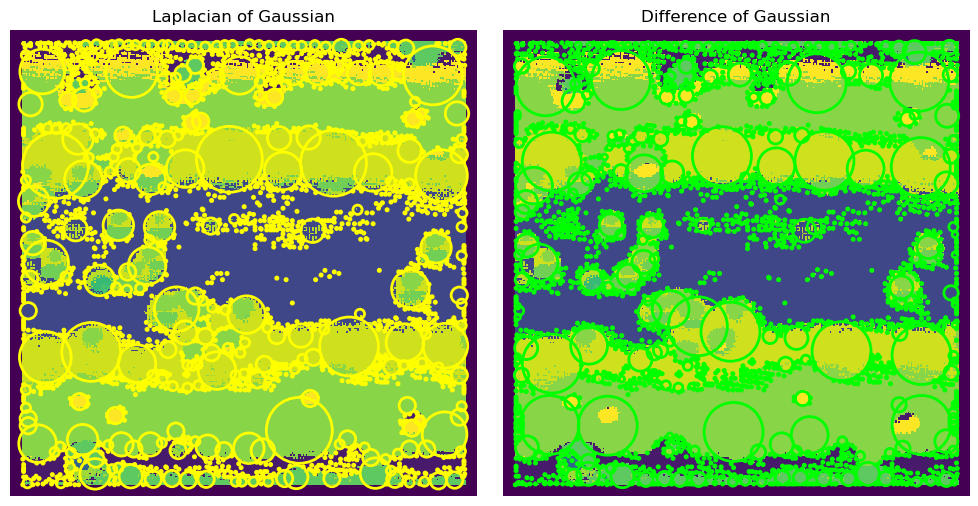

In [62]:
from skimage.color import rgb2gray
from skimage.feature import blob_dog, blob_log, blob_doh
from math import sqrt

image_gray = cluster_img.astype(float)
blobs_log = blob_log(image_gray, max_sigma=30, num_sigma=10, threshold=0.1)
print("Number of blobs detected using LoG:", len(blobs_log))
# Compute radii in the 3rd column.
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

blobs_dog = blob_dog(image_gray, max_sigma=30, threshold=0.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)
print("Number of blobs detected using DoG:", len(blobs_dog))

#blobs_doh = blob_doh(image_gray, max_sigma=30, threshold=0.01)
#print
blobs_list = [blobs_log, blobs_dog]
colors = ['yellow', 'lime', ]
titles = ['Laplacian of Gaussian', 'Difference of Gaussian', 'Determinant of Hessian']
sequence = zip(blobs_list, colors, titles)

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
ax = axes.ravel()

for idx, (blobs, color, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(cluster_img, interpolation='nearest')
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()

plt.tight_layout()
plt.show()

### I wasn't able to figure out how to stop it from detecting the edges

In [63]:
image_gray = cluster_img.astype(float)
image_gray = np.expand_dims(image_gray, axis=-1)  # Now shape is (900, 900, 1)


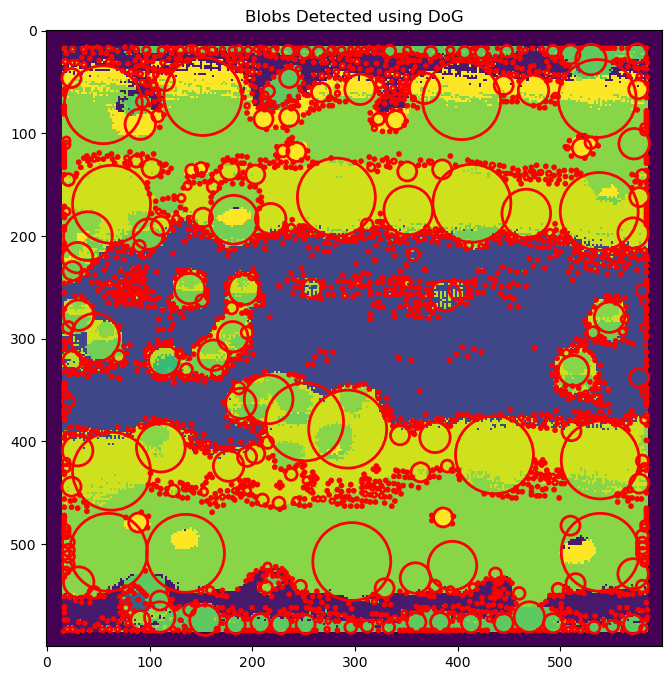

In [65]:
fig, ax = plt.subplots(figsize=(10, 8))  # Adjust figsize (width, height) as desired
color = 'red'  # Color for the circles
ax.set_title('Blobs Detected using DoG')
ax.imshow(cluster_img, interpolation='nearest')
for blob in blobs_dog:
    y, x, r = blob
    c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
    ax.add_patch(c)